<a href="https://colab.research.google.com/github/noraleilaa/453/blob/main/A_1_Tokens_and_Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 01 - First Vectorized Representation


Our goal in this exercise is to BEGIN coming to a common agreement, among this class, as to what terms we will use as we selectively refine our corpus-wide vocabulary. This corpus vocabulary is what would represent the content of each different document for clustering and classification purposes, which will be our next step. This means that we need to make decisions - what is in, what is out.

In [1]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br>
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Drive

In [2]:
from google.colab import drive
#drive.mount('/content/gdrive/My Drive')
##drive.mount('/content/gdrive/')

### NLTK Downloads

In [3]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [4]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [5]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Utility Functions

In [7]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []

    stop_words = set(nltk.corpus.stopwords.words('english'))
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))

    return result

def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
    data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
    data['is_action'] = data.index.isin(action_doc_ids)

def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

## Loading the corpus

In [8]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [9]:
# CORPUS_PATH = './data/MSDS453_Sec57_TestQA_ClassCorpus.csv'
# corpus_df = get_corpus_df(CORPUS_PATH)
# documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

## Exploritory Data Analysis

In [10]:
corpus_df.shape

(200, 9)

In [11]:
corpus_df.head(4).T

Doc_ID                                                                   90  \
DSI_Title                                         LKP_Doc1_Angel_has_fallen   
Text                      Target is on the move . '' Heavily outnumbered...   
Submission File Name                              LKP_Doc1_Angel_has_fallen   
Student Name                                                            LKP   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_has_fallen   
Descriptor                                     Action_Angel_has_fallen_N_90   
Doc_ID                                                                   90   

Doc_ID                                                                   91  \
DSI_Title                                         LKP_Doc2_Angel_has_fallen   
Text                      The sleepy , dopey action bonanza `` Angel Has...   
Submission File Name                              LKP_Doc2_Angel_has_fallen   
Student Name                                                            LKP   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_has_fallen   
Descriptor                                     Action_Angel_has_fallen_N_91   
Doc_ID                                                                   91   

Doc_ID                                                                   92  \
DSI_Title                                         LKP_Doc3_Angel_has_fallen   
Text                      `` Angel Has Fallen '' marks the third time th...   
Submission File Name                              LKP_Doc3_Angel_has_fallen   
Student Name                                                            LKP   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_has_fallen   
Descriptor                                     Action_Angel_has_fallen_N_92   
Doc_ID                                                                   92   

Doc_ID                                                                   93  
DSI_Title                                         LKP_Doc4_Angel_has_fallen  
Text                      Improving through blandness . So Mike Banning ...  
Submission File Name                              LKP_Doc4_Angel_has_fallen  
Student Name                                                            LKP  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel_has_fallen  
Descriptor                                     Action_Angel_has_fallen_N_93  
Doc_ID                                                                   93

In [12]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB
None


In [13]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


## Number of Reviews By Genre

In [14]:
counts_df = corpus_df[['Genre of Movie']].copy()
counts_df['Count'] = 1
counts_df.groupby(['Genre of Movie']).count().reset_index()

Genre of Movie  Count
0         Action     50
1         Comedy     50
2         Horror     50
3         Sci-Fi     50

In [15]:
corpus_df.columns

Index(['DSI_Title', 'Text', 'Submission File Name', 'Student Name',
       'Genre of Movie', 'Review Type (pos or neg)', 'Movie Title',
       'Descriptor', 'Doc_ID'],
      dtype='object')

## Normalized Document

1. remove_punctuation(text)
2. lower_case(text)
3. remove_tags(text)
4. remove_special_chars_and_digits(text)
5. return Document(document.doc_id, text)

In [16]:
normalized_documents = normalize_documents(documents)
normalized_documents[0]

Document(doc_id=90, text='target is on the move heavily outnumbered and outgunned mike banning gerard butler strives to exit a multi level bullet riddled structure as squadrons of soldiers descend upon his position but thanks to his skills he s perfectly capable of overcoming the incredible odds or at least that s what the overwrought editing will have audiences assume in this opening sequence alone the camerawork is so shaky and hard to follow that it s impossible to know exactly what is going on back in washington d c banning awaits an offer to become the director of the secret service for president allan trumbull morgan freeman but despite his many years on the job working to protect the president from all sorts of mayhem mike is n t certain he s ready to sit behind a desk for the rest of his career his abuse of pills for migraines dizziness and insomnia does n t help in making the decision though his wife leah piper perabo and their infant daughter lynn would probably appreciate th

## Standardize Document

#### NLTK Tokenizer Package

https://www.nltk.org/api/nltk.tokenize.html

Tokenizers divide strings into lists of substrings. For example, tokenizers can be used to find the words and punctuation in a string:

### Functions for Tokenization Process
1. tokenize_document
2. tokenize_documents

In [17]:
tokenized_documents = tokenize_documents(normalized_documents)
tokenized_documents[0]

TokenizedDocument(doc_id=90, tokens=['target', 'is', 'on', 'the', 'move', 'heavily', 'outnumbered', 'and', 'outgunned', 'mike', 'banning', 'gerard', 'butler', 'strives', 'to', 'exit', 'a', 'multi', 'level', 'bullet', 'riddled', 'structure', 'as', 'squadrons', 'of', 'soldiers', 'descend', 'upon', 'his', 'position', 'but', 'thanks', 'to', 'his', 'skills', 'he', 's', 'perfectly', 'capable', 'of', 'overcoming', 'the', 'incredible', 'odds', 'or', 'at', 'least', 'that', 's', 'what', 'the', 'overwrought', 'editing', 'will', 'have', 'audiences', 'assume', 'in', 'this', 'opening', 'sequence', 'alone', 'the', 'camerawork', 'is', 'so', 'shaky', 'and', 'hard', 'to', 'follow', 'that', 'it', 's', 'impossible', 'to', 'know', 'exactly', 'what', 'is', 'going', 'on', 'back', 'in', 'washington', 'd', 'c', 'banning', 'awaits', 'an', 'offer', 'to', 'become', 'the', 'director', 'of', 'the', 'secret', 'service', 'for', 'president', 'allan', 'trumbull', 'morgan', 'freeman', 'but', 'despite', 'his', 'many', 'y

## Useful Lookups (Titles by DocID, Genres by DocID, Description by DocID)

In [18]:
titles_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Movie Title'])}
genres_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Genre of Movie'])}
descriptors_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Descriptor'])}

action_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] == 'Action']
action_documents = [x for x in documents if x.doc_id in action_doc_ids]

non_action_doc_ids = {int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] != 'Action'}
non_action_documents = [x for x in documents if x.doc_id in non_action_doc_ids]

## Lookup for Specific Movie Title

In [19]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


In [20]:
casino_royale_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if titles_by_doc_ids[x] == 'Batman']
casino_royale_documents = [x for x in documents if x.doc_id in casino_royale_doc_ids]

## Qualitative Term Determinations

#### Terms Determined by Document of Interest

In [21]:
candidate_terms = [
    'action',
    'sequence',
    'grit',
    'plot',
    'chase',
    'airline',
    'stock',
    'series',
    'effect',
    'strong',
    'theme',
    'character',
    'money',
    'spy'
]

## CountVectorizer

<div class="alert alert-block alert-success">
    <b>sklearn.feature_extraction.text.CountVectorizer</b>:<br>
Convert a collection of text documents to a matrix of token counts.<br>
This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.<br>
If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.
</div>

In [22]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
text_for_counts = [x.text for x in normalized_documents]
matrix = vectorizer.fit_transform(text_for_counts)
words = vectorizer.get_feature_names_out()
word_counts = pd.DataFrame(matrix.toarray(), columns=words, index=corpus_df.Doc_ID)

In [23]:
add_flags(word_counts, casino_royale_doc_ids, action_doc_ids)
word_counts['Doc_ID'] = word_counts.index

In [24]:
# Collect result into a dataframe
mean_frequencies = pd.DataFrame(index=candidate_terms)

casino_royale_mean_frequencies = word_counts[word_counts.is_casino_royale][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['Batman'] = casino_royale_mean_frequencies

action_mean_frequencies = word_counts[word_counts.is_action][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Action'] = action_mean_frequencies

non_action_mean_frequencies = word_counts[~word_counts.is_action][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Non-Action'] = non_action_mean_frequencies

In [25]:
mean_frequencies.fillna(0.0).sort_values(['Batman'], ascending=False)

Batman  All Action  All Non-Action
action        0.0        1.70        0.306667
sequence      0.0        0.18        0.093333
grit          0.0        0.00        0.006667
plot          0.0        0.78        0.220000
chase         0.0        0.10        0.026667
airline       0.0        0.00        0.000000
stock         0.0        0.14        0.020000
series        0.0        0.40        0.106667
effect        0.0        0.02        0.060000
strong        0.0        0.14        0.060000
theme         0.0        0.02        0.033333
character     0.0        0.70        0.420000
money         0.0        0.10        0.026667
spy           0.0        0.16        0.033333

In [26]:
# These are identified
important_prevalent_terms = [
    'action',
    'series',
    'money',
    'chase'
]
stemmer = PorterStemmer()
stemmed_important_prevalent_terms = [stemmer.stem(x) for x in important_prevalent_terms]

In [27]:
pd.options.display.float_format = '{:,.2f}'.format
mean_frequencies.fillna(0.0).loc[important_prevalent_terms].round(2).sort_values(['Batman'], ascending=False)

Batman  All Action  All Non-Action
action    0.00        1.70            0.31
series    0.00        0.40            0.11
money     0.00        0.10            0.03
chase     0.00        0.10            0.03

## TF-IDF Experiment Functions - Text Normalization

In [28]:
def run_tfidf(documents: List[Document],
              clean_func: Callable[[List[Document]], List[TokenizedDocument]],
              important_prevalent_terms: List[str],
              experiment_name: str,
              output_tfidf_vectors: bool=False,
              output_vocabulary: bool=True):
    cleaned_documents = clean_func(documents)
    cleaned_document_text = [' '.join(x.tokens) for x in cleaned_documents]

    vectorizer = TfidfVectorizer(use_idf=True,
                                 ngram_range=(1, 1),
                                 norm=None)

    transformed_documents = vectorizer.fit_transform(cleaned_document_text)
    transformed_documents_as_array = transformed_documents.toarray()

    output_dir = f'output/{experiment_name}_Results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if output_tfidf_vectors:
        for counter, doc in enumerate(transformed_documents_as_array):
            tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
            one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score'])\
                                        .sort_values(by='score', ascending=False)\
                                        .reset_index(drop=True)

            one_doc_as_df.to_csv(f'{output_dir}/{corpus_df["Submission File Name"][counter]}')

    if output_vocabulary:
        with open(f'{output_dir}/vocabulary.txt', 'w') as vocab:
            words = sorted(vectorizer.get_feature_names_out())
            print('\n'.join(words), file=vocab)

    # Create document-term dataframe
    doc_term_matrix = transformed_documents.todense()
    doc_term_df = pd.DataFrame(doc_term_matrix,
                               columns=vectorizer.get_feature_names_out(),
                               index=corpus_df.Doc_ID)
    add_flags(doc_term_df, casino_royale_doc_ids, action_doc_ids)

    # Print the top 10 mean TF-IDF values
    top10_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(10))
    top10_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)
    display(top10_tfidf)

    # Collect result into a dataframe
    tfidf_results = pd.DataFrame(index=important_prevalent_terms)

    all_tfidf_results = doc_term_df[[x for x in important_prevalent_terms if x in doc_term_df.columns]].mean().round(2)
    tfidf_results['All Movies'] = all_tfidf_results

    plt.hist(doc_term_df.mean(), 100, range=(0, 8))

    print(f'Vocabulary size: {doc_term_df.shape[1]}')

    descriptors = corpus_df['Descriptor']

    similarities = cosine_similarity(doc_term_df.loc[action_doc_ids], doc_term_df.loc[action_doc_ids])
    fig, ax = plt.subplots(figsize=(30, 30))
    labels = [descriptors_by_doc_ids[x.doc_id] for x in action_documents]
    sns.heatmap(ax=ax, data=similarities, xticklabels=labels, yticklabels=labels)
    #plt.savefig(f'figures/{experiment_name}_heatmap_documents.png')
    plt.show()

## TF-IDF  (Term Frequency-Inverse Document Frequency)

### Experiments, Normalize, Tokenize, Lemmatization and Stop Word Removal

In [29]:
def clean_method(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes, lemmatizes, and removes stop words.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = lemmatize(documents)
    documents = remove_stop_words(documents)
    documents = stem(documents)

    return documents

Mean TF-IDF
film            3.57
movi            3.07
wa              2.59
ha              2.48
like            2.15
one             1.94
time            1.83
charact         1.67
barbi           1.66
bond            1.55

Vocabulary size: 7772


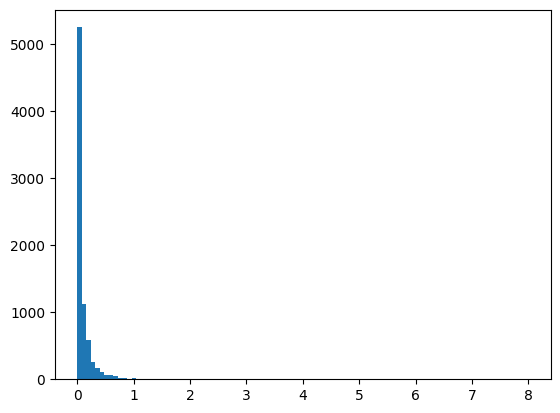

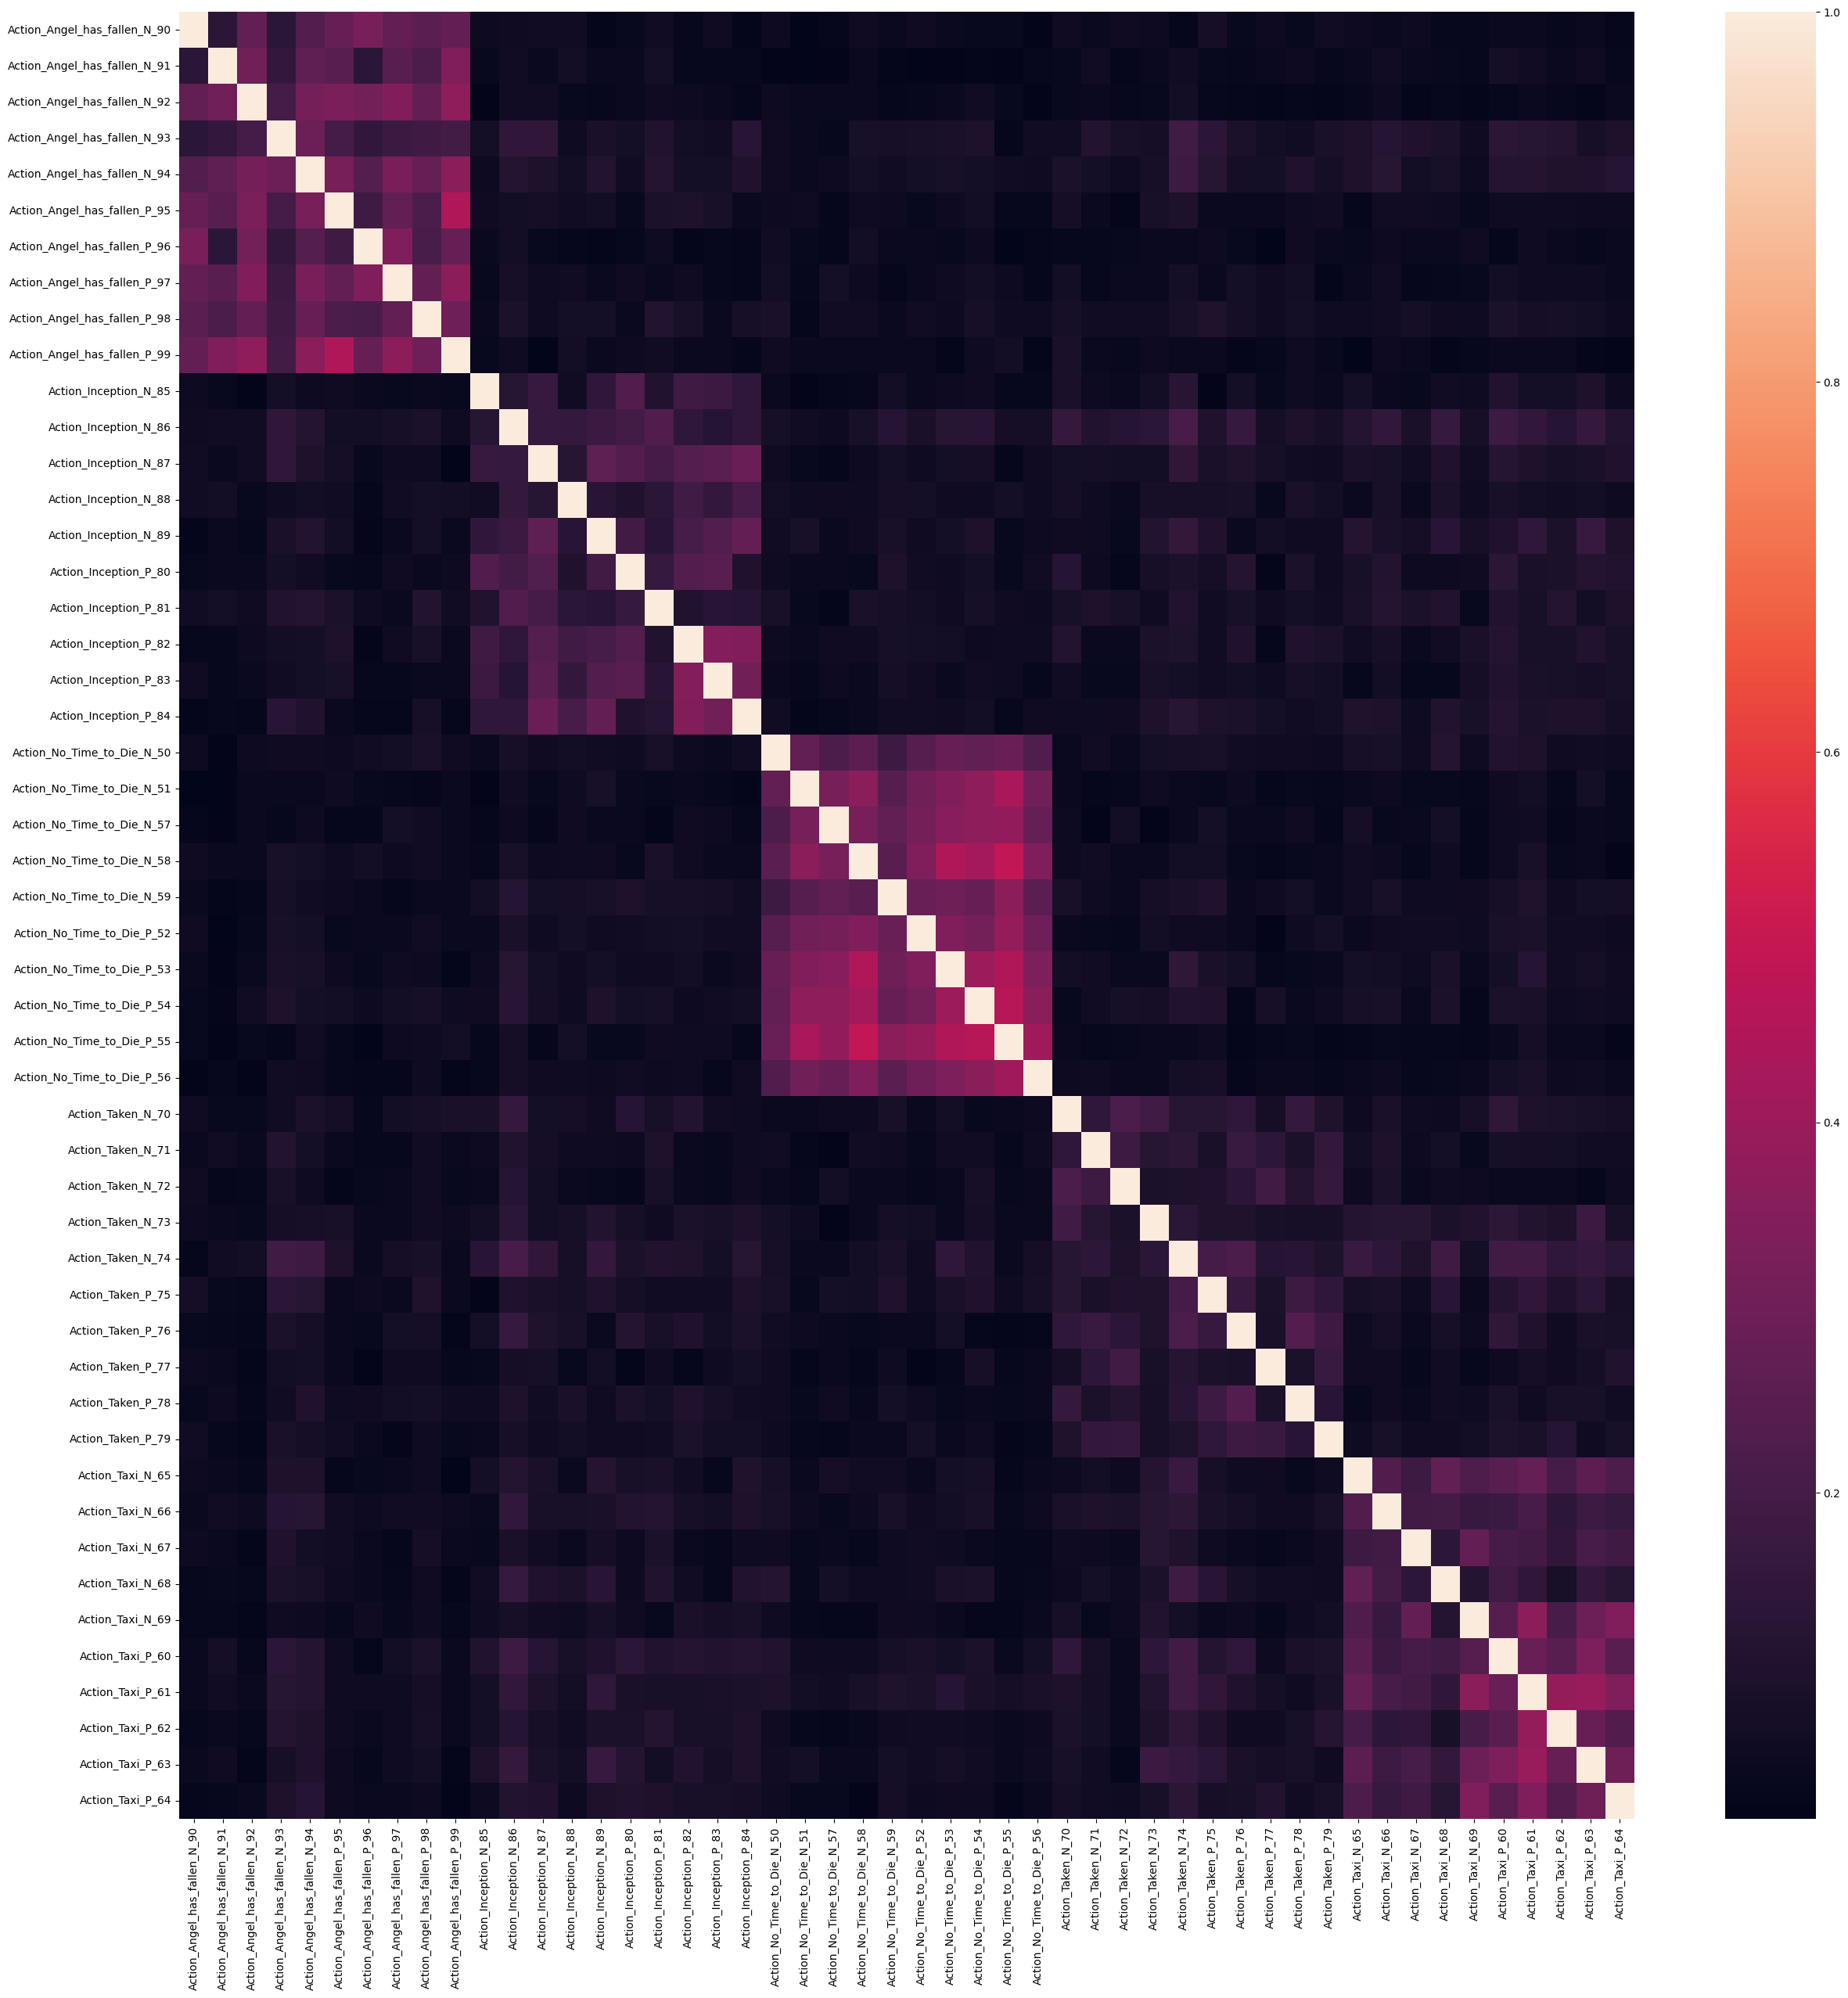

In [30]:
run_tfidf(documents, clean_method, important_prevalent_terms, 'TFIDF_exp')

## Word2Vec

<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

## Utility Functions For Word2Vec Experiments

In [31]:
def get_word2vec_vectors(documents: List[TokenizedDocument], embedding_size: int) -> pd.DataFrame:
    tokens = [x.tokens for x in documents]

    # https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

    # gensim 3.8
    #word2vec_model = Word2Vec(tokens, size=embedding_size, window=3, min_count=1, workers=12)

    # gensim 4.3.1
    word2vec_model = Word2Vec(sentences=tokens, vector_size=embedding_size, window=3, min_count=1, workers=12)

    # gensim 3.8
    #vectors = {}
    #for i in word2vec_model.wv.vocab:
    #    temp_vec = word2vec_model.wv[i]
    #    vectors[i] = temp_vec

    # gensim 4.3.1
    vectors = {}
    for i in word2vec_model.wv.index_to_key:
        temp_vec = word2vec_model.wv[i]
        vectors[i] = temp_vec

    # Changes made:
    #   1. The size parameter in Word2Vec has been renamed to vector_size.
    #   2. Instead of iterating through word2vec_model.wv.vocab, you should now use
    #      word2vec_model.wv.index_to_key to get the list of words in the vocabulary.


    result = pd.DataFrame(vectors).transpose()
    result = result.sort_index()
    return result

def plot_similarity_matrix(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(ax=ax, data=similarities, xticklabels=data.index, yticklabels=data.index);
    #plt.savefig(f'figures/{experiment_name}_heatmap.png')
    plt.close()

def plot_similarity_clustermap(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    cm = sns.clustermap(similarities, metric='cosine', xticklabels=data.index, yticklabels=data.index, method='complete', cmap='RdBu', figsize=figsize)
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    plt.legend(loc='upper left')
    #plt.savefig(f'figures/{experiment_name}_clustermap.png')
    plt.show()
    plt.close()

def plot_tsne(data: pd.DataFrame, perplexity: int, experiment_name: str, figsize=(40, 40)):
    """
    Creates a TSNE plot of the supplied dataframe
    """
    tsne_model = TSNE(perplexity=perplexity, n_components=2, learning_rate='auto', init='pca', n_iter=1000, random_state=32)
    new_values = tsne_model.fit_transform(data)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)
    labels = list(data.index)
    for i in range(len(x)):
        new_value = new_values[i]
        x = new_value[0]
        y = new_value[1]

        plt.scatter(x, y)
        plt.annotate(labels[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.savefig(f'figures/{experiment_name}_tsne.png')
    plt.show()
    plt.close()

def run_word2vec_experiment(documents: List[Document],
                            clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                            embedding_size: int,
                            chosen_tokens: List[str],
                            experiment_name: str):
    cleaned_documents = clean_func(documents)

    word2vec_df = get_word2vec_vectors(cleaned_documents, embedding_size)
    filtered_word2vec_df = word2vec_df.loc[chosen_tokens].copy()

    plot_tsne(filtered_word2vec_df, 30, experiment_name)
    plot_similarity_matrix(filtered_word2vec_df, experiment_name)
    plot_similarity_clustermap(filtered_word2vec_df, experiment_name)

In [32]:
extra_terms = [
    'bond',
    'craig',
    'star',
    'casino',
    'action'
]

In [33]:
# Get our terms to examine in experiements 4-12
all_tokens = get_all_tokens(remove_stop_words(clean_method(documents)))
chosen_tokens = random.choices(all_tokens, k=100 - len(extra_terms)) + extra_terms

lemmatizer = WordNetLemmatizer()
lemmatized_chosen_tokens = [lemmatizer.lemmatize(x) for x in chosen_tokens]
stemmed_chosen_tokens = [stemmer.stem(x) for x in lemmatized_chosen_tokens]

## Word2Vec Experiments:


<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

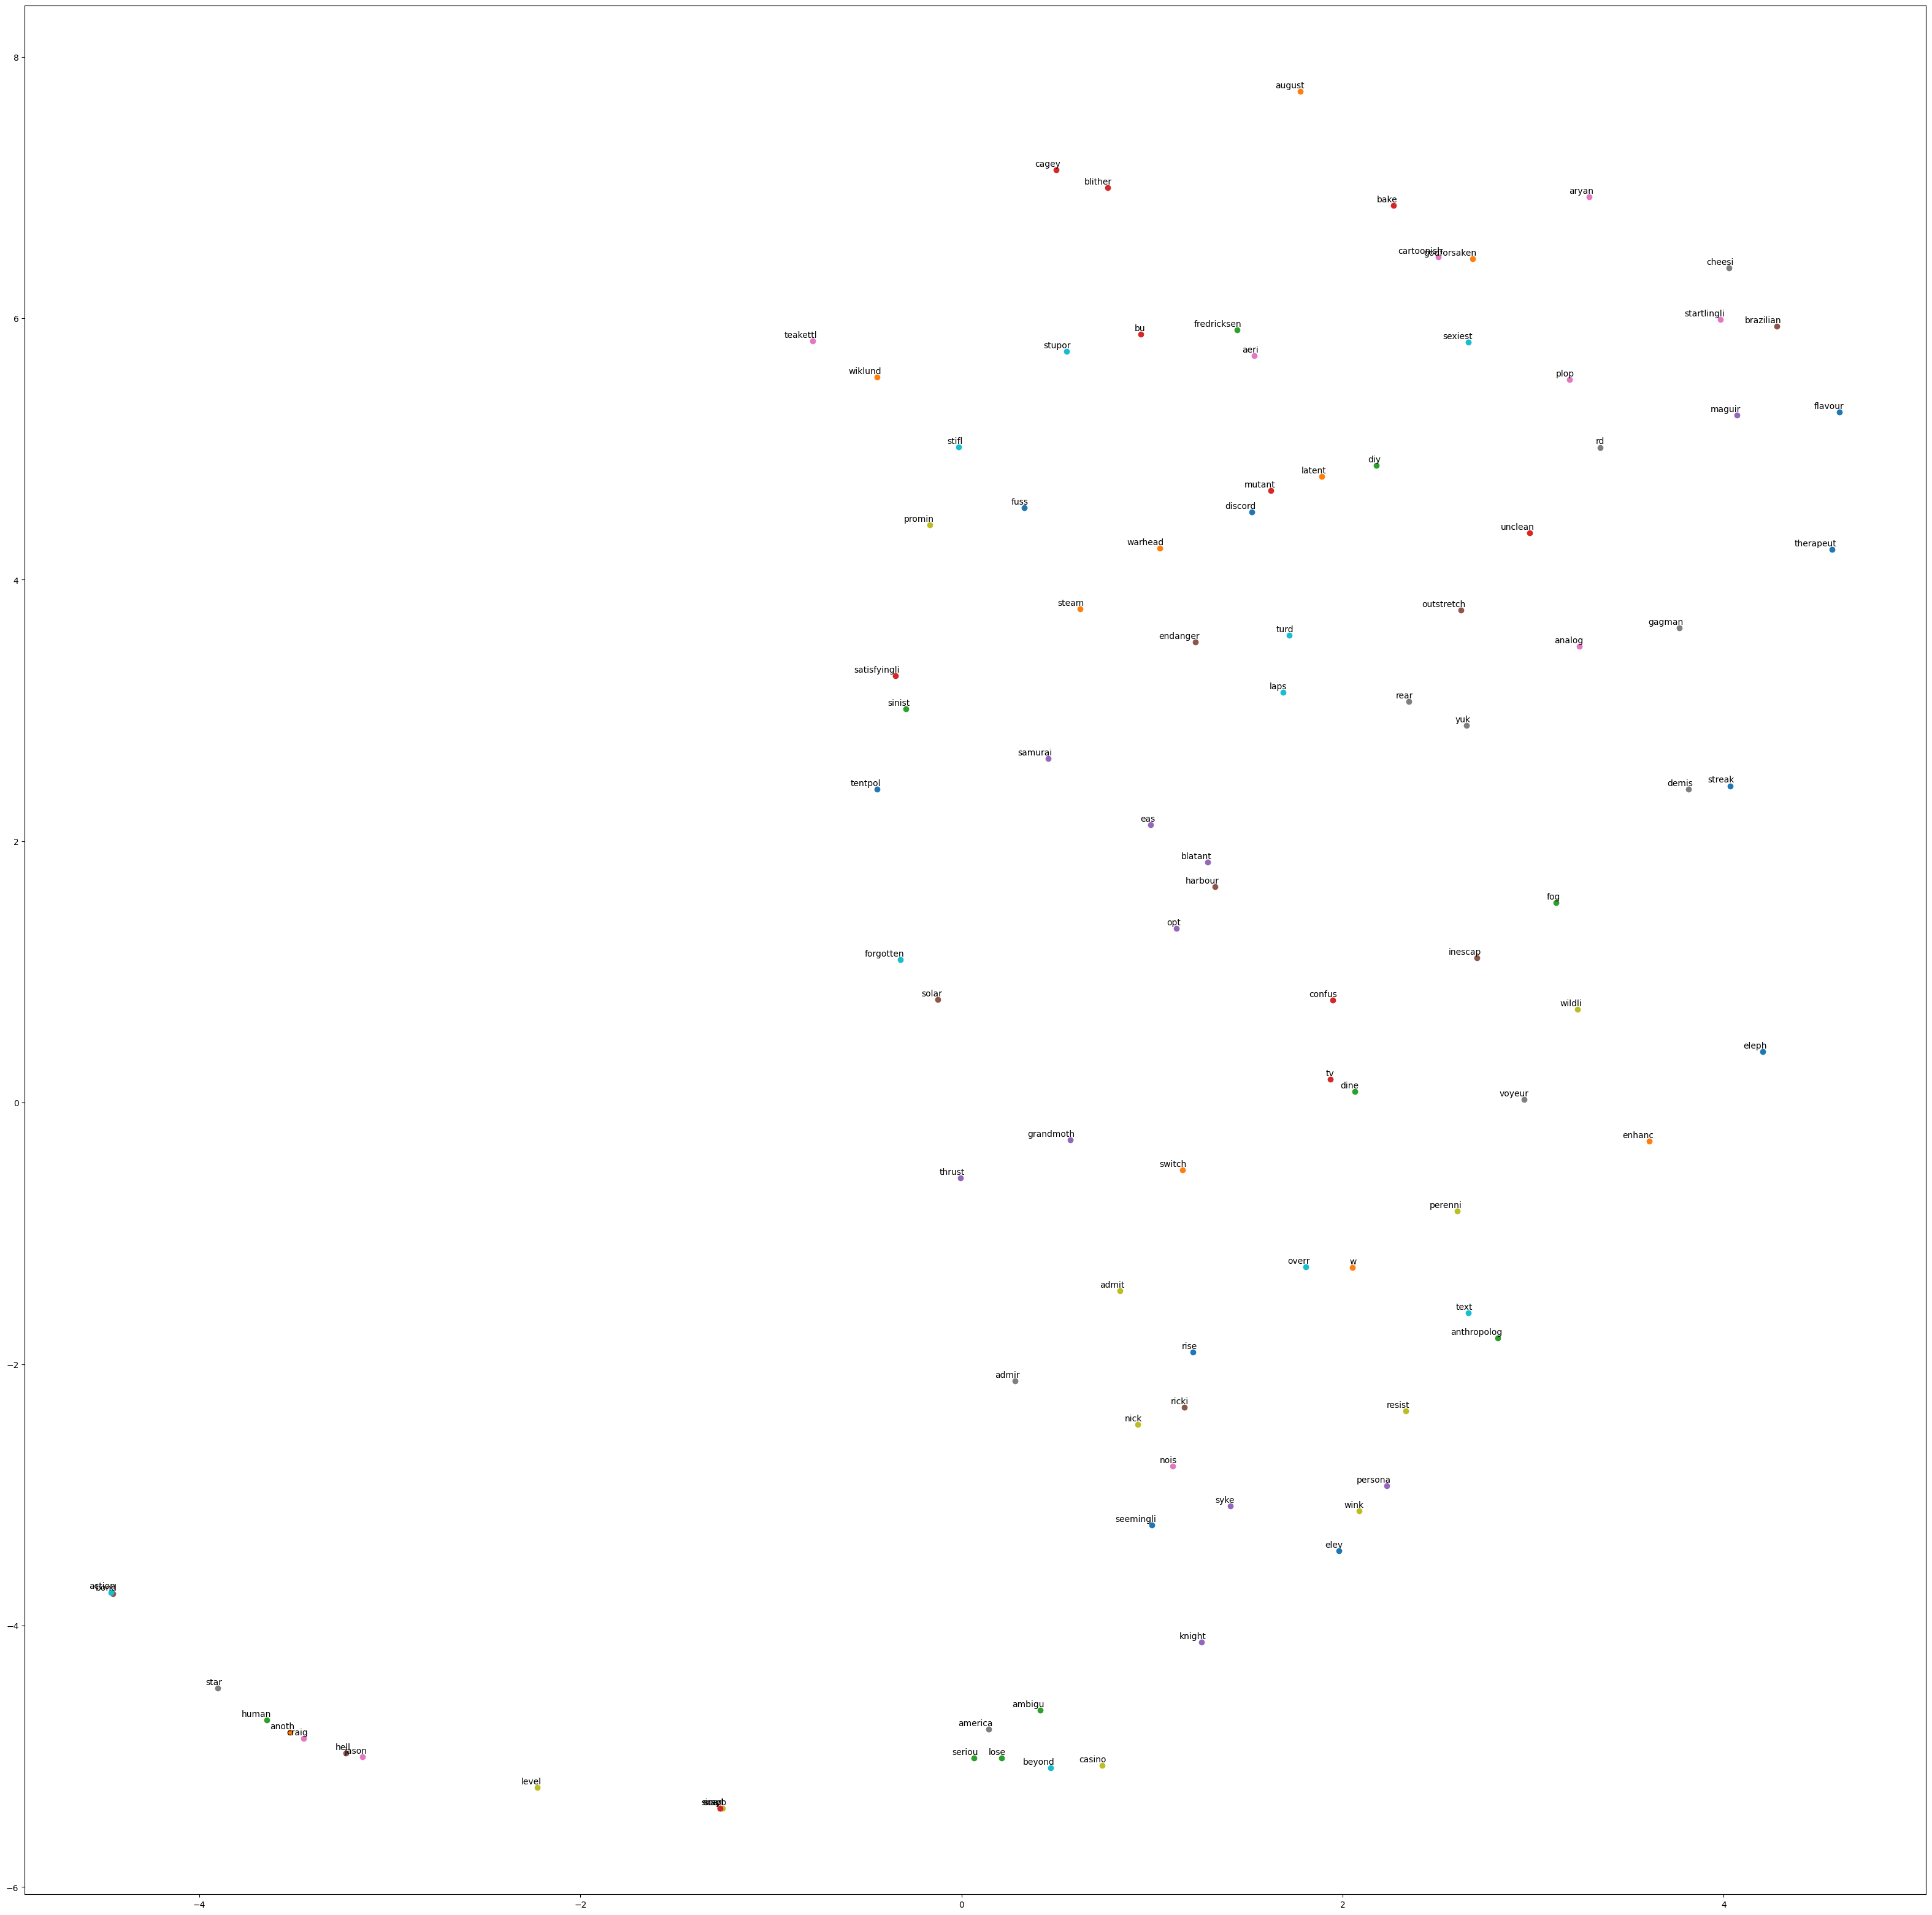

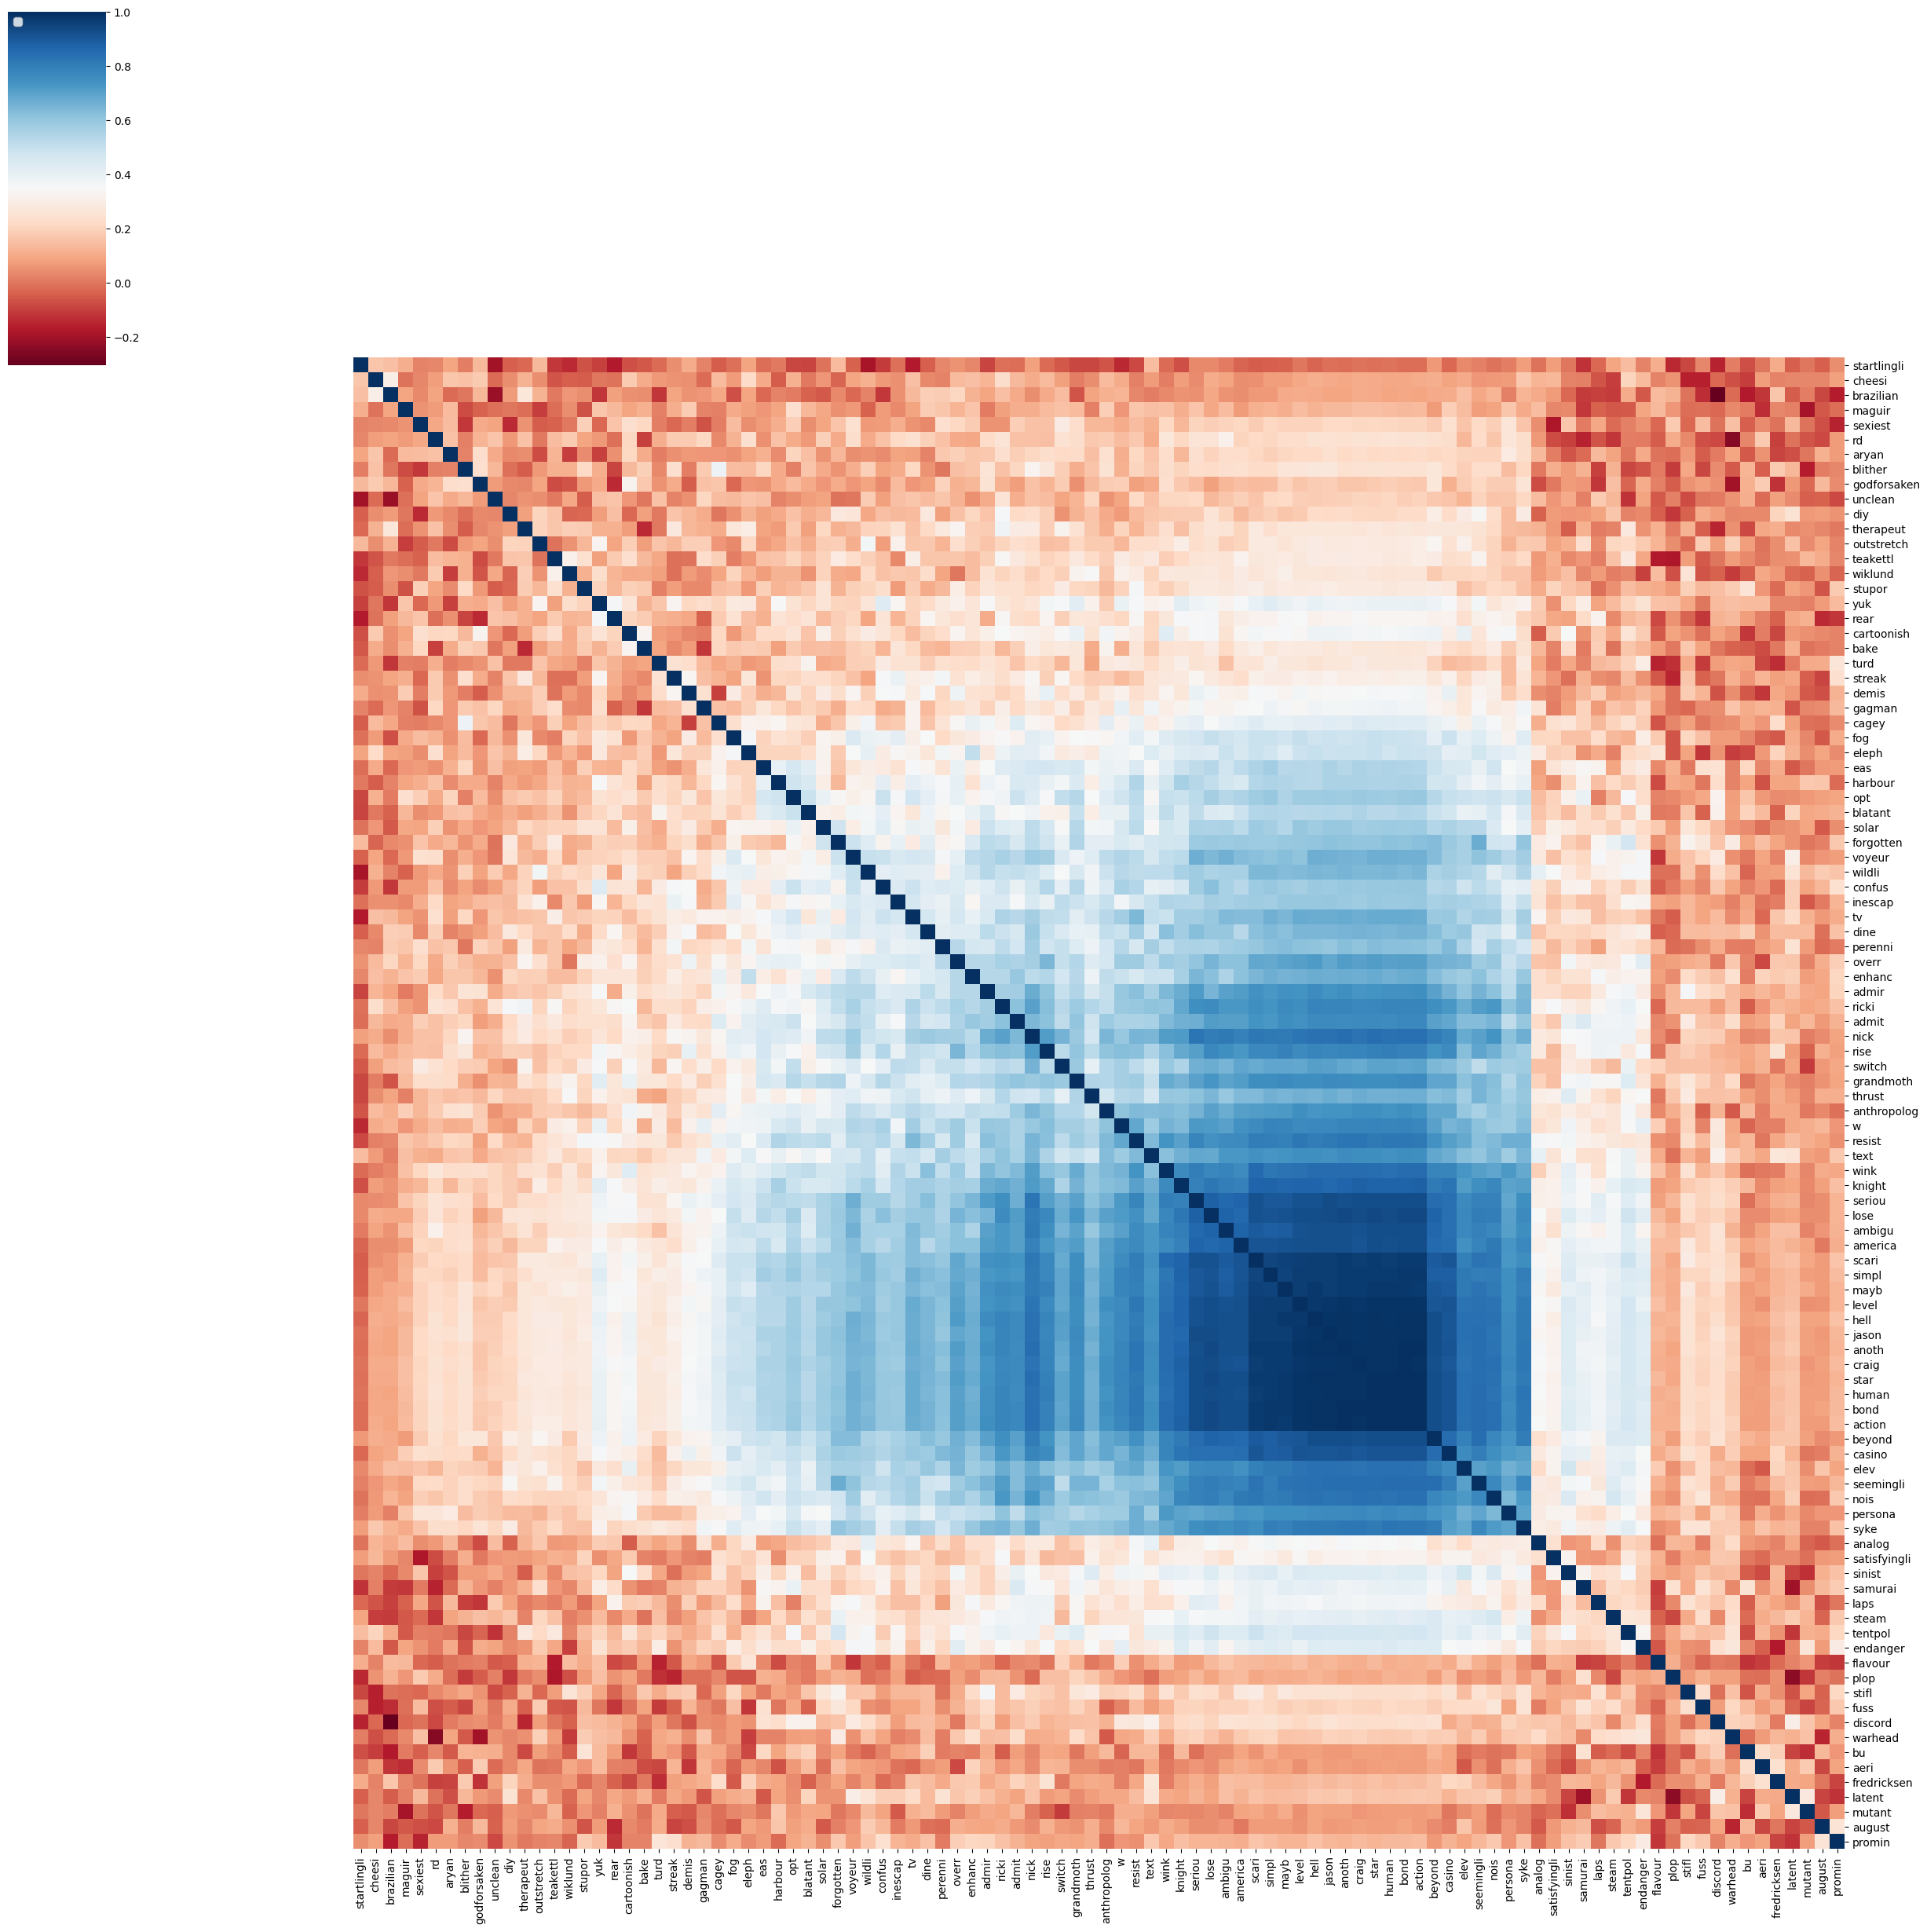

In [34]:
run_word2vec_experiment(documents, clean_method, 100, chosen_tokens, 'Word2Vec_exp')

## Utility functions for Doc2Vec experiments

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

In [35]:
def run_doc2vec(documents: List[TokenizedDocument], embedding_size: int, descriptors_by_doc_ids: Dict[int, str]):
    tagged_documents = [TaggedDocument(document.tokens, [i]) for i, document in enumerate(documents)]
    doc2vec_model = Doc2Vec(tagged_documents, vector_size=embedding_size, window=3, min_count=2, workers=12)

    doc2vec_df = pd.DataFrame()
    for document in documents:
        vector = pd.DataFrame(doc2vec_model.infer_vector(document.tokens)).transpose()
        doc2vec_df = pd.concat([doc2vec_df, vector], axis=0)

    doc2vec_df['Descriptor'] = [descriptors_by_doc_ids[x.doc_id] for x in documents]
    doc2vec_df.set_index(['Descriptor'], inplace=True)
    return doc2vec_df

def run_doc2vec_experiment(documents: List[Document],
                           clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                           embedding_size: int,
                           experiment_name: str):
    cleaned_documents = clean_func(documents)
    doc2vec_df = run_doc2vec(cleaned_documents, embedding_size, descriptors_by_doc_ids)

    plot_similarity_matrix(doc2vec_df, experiment_name)
    plot_similarity_clustermap(doc2vec_df, experiment_name, figsize=(50, 50))
    plot_tsne(doc2vec_df, 30, experiment_name)

## Doc2Vec Experiments:

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

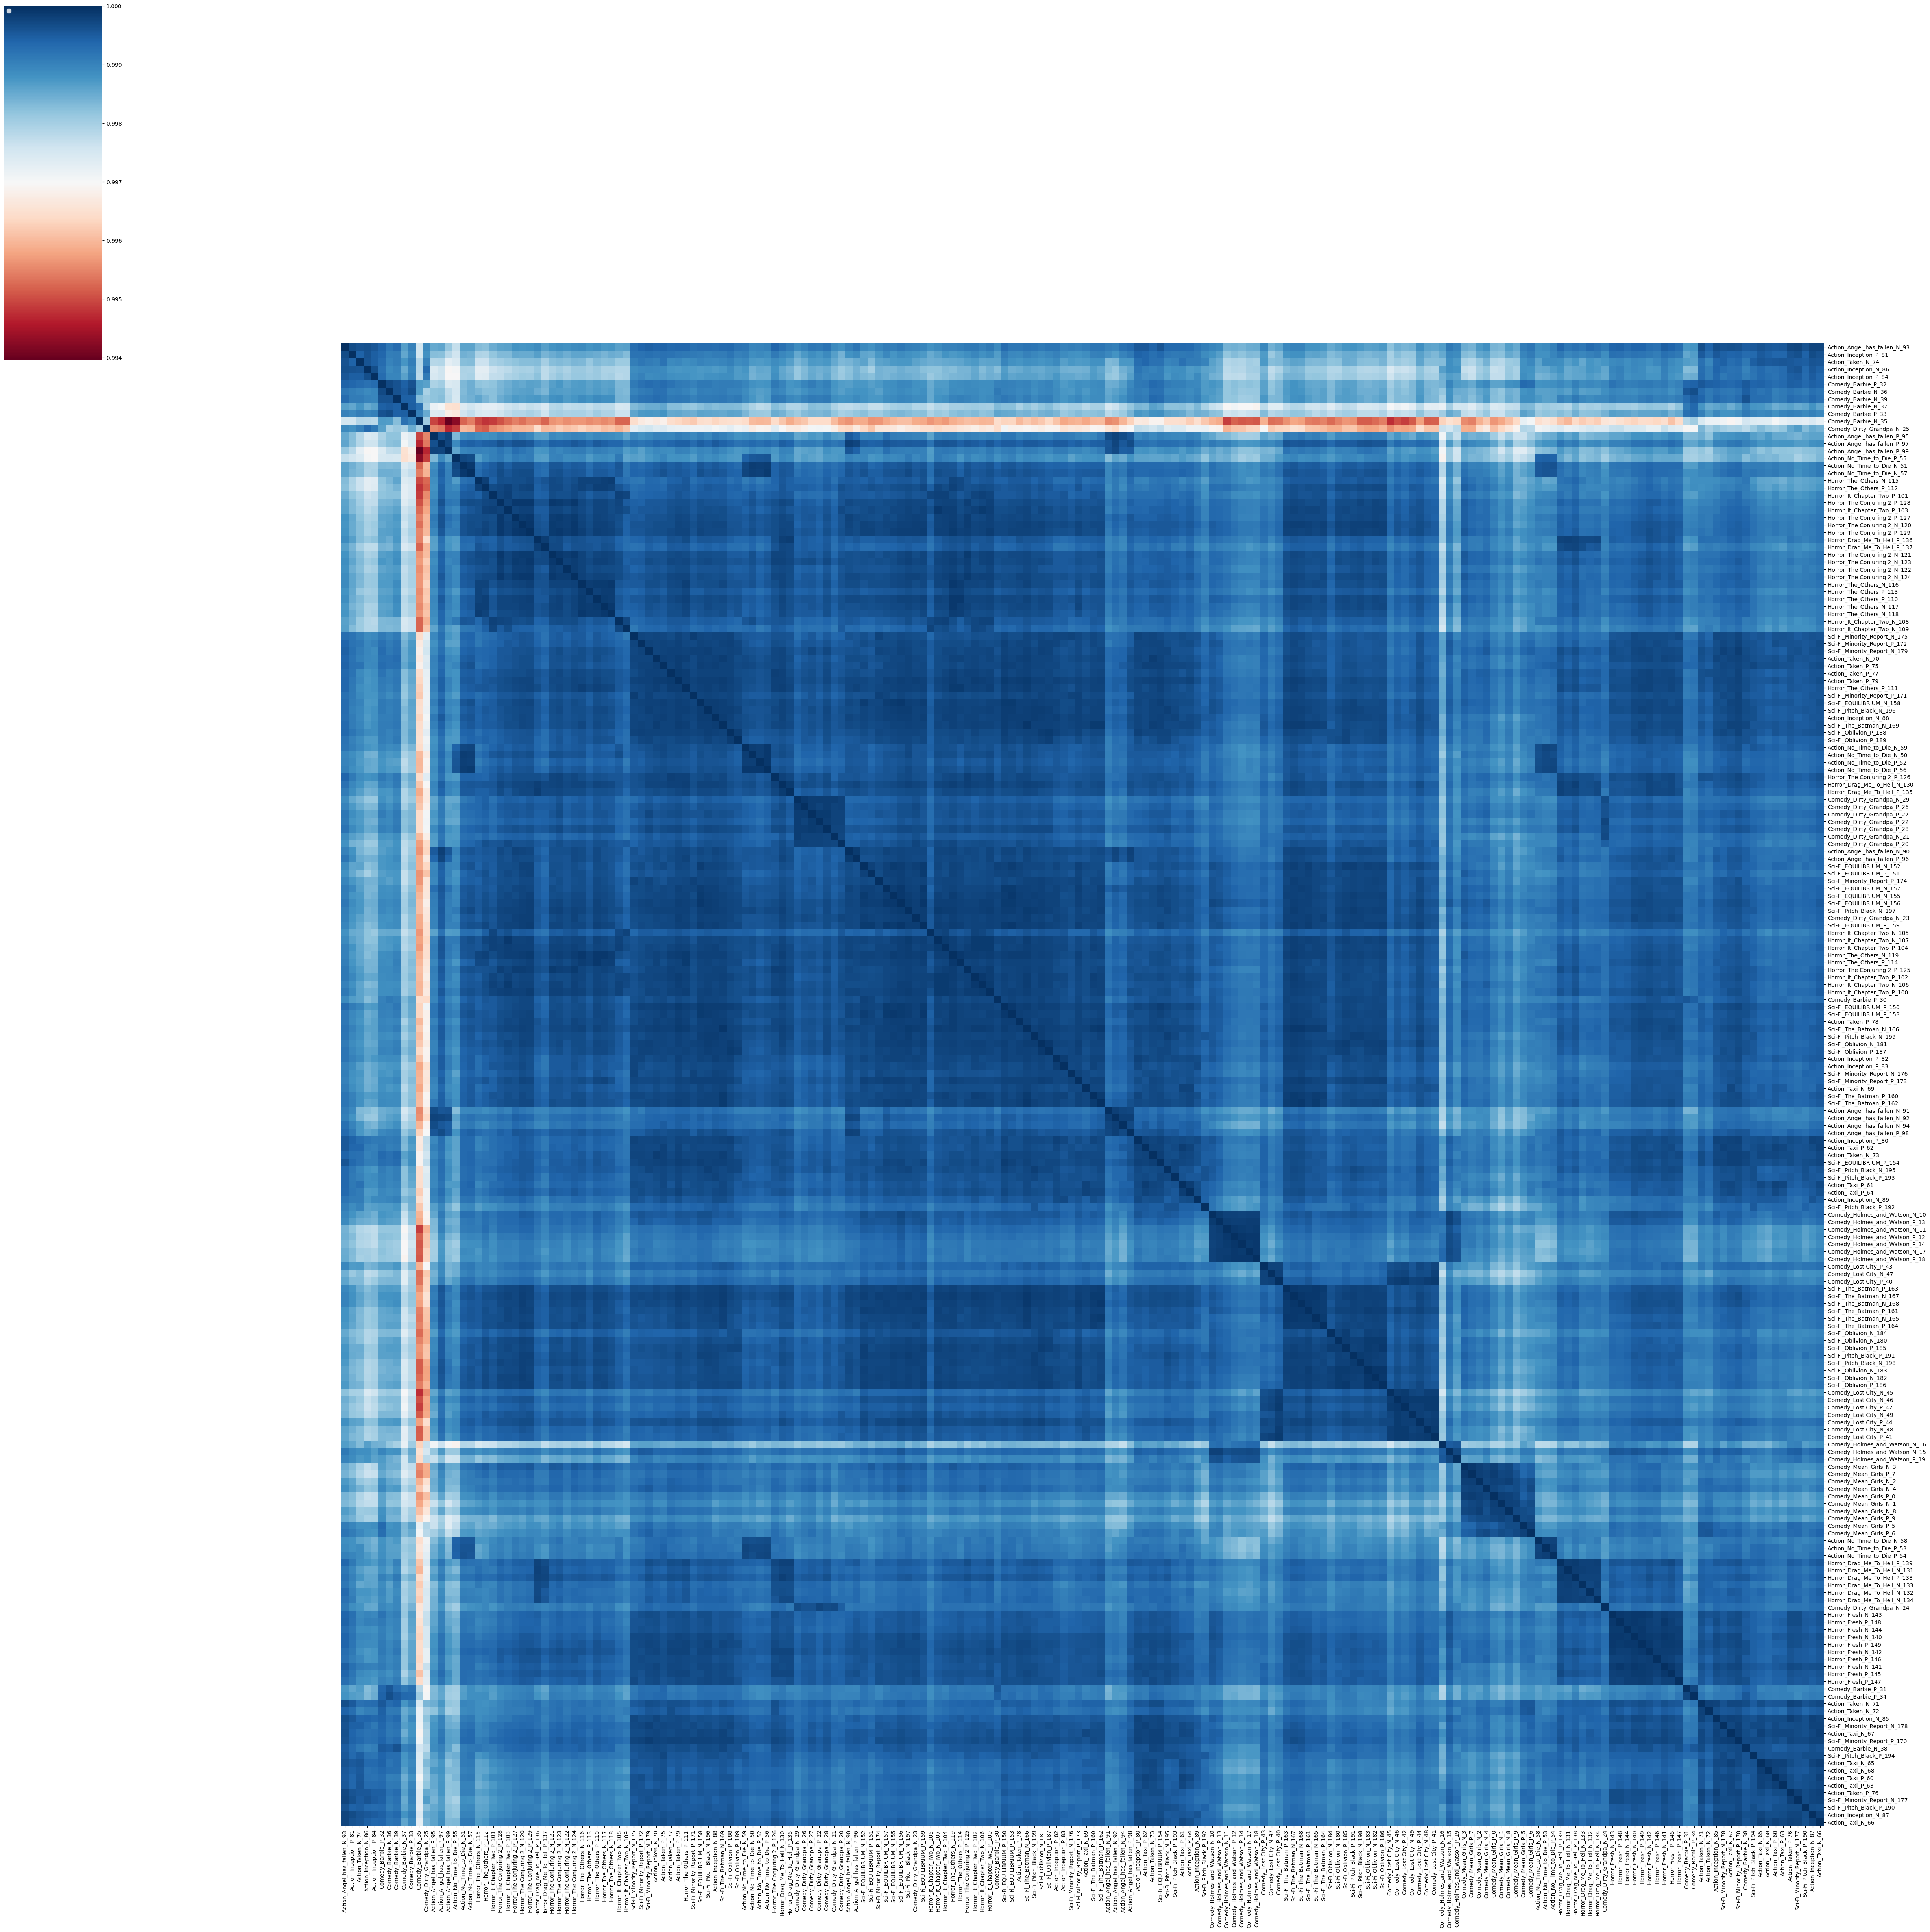

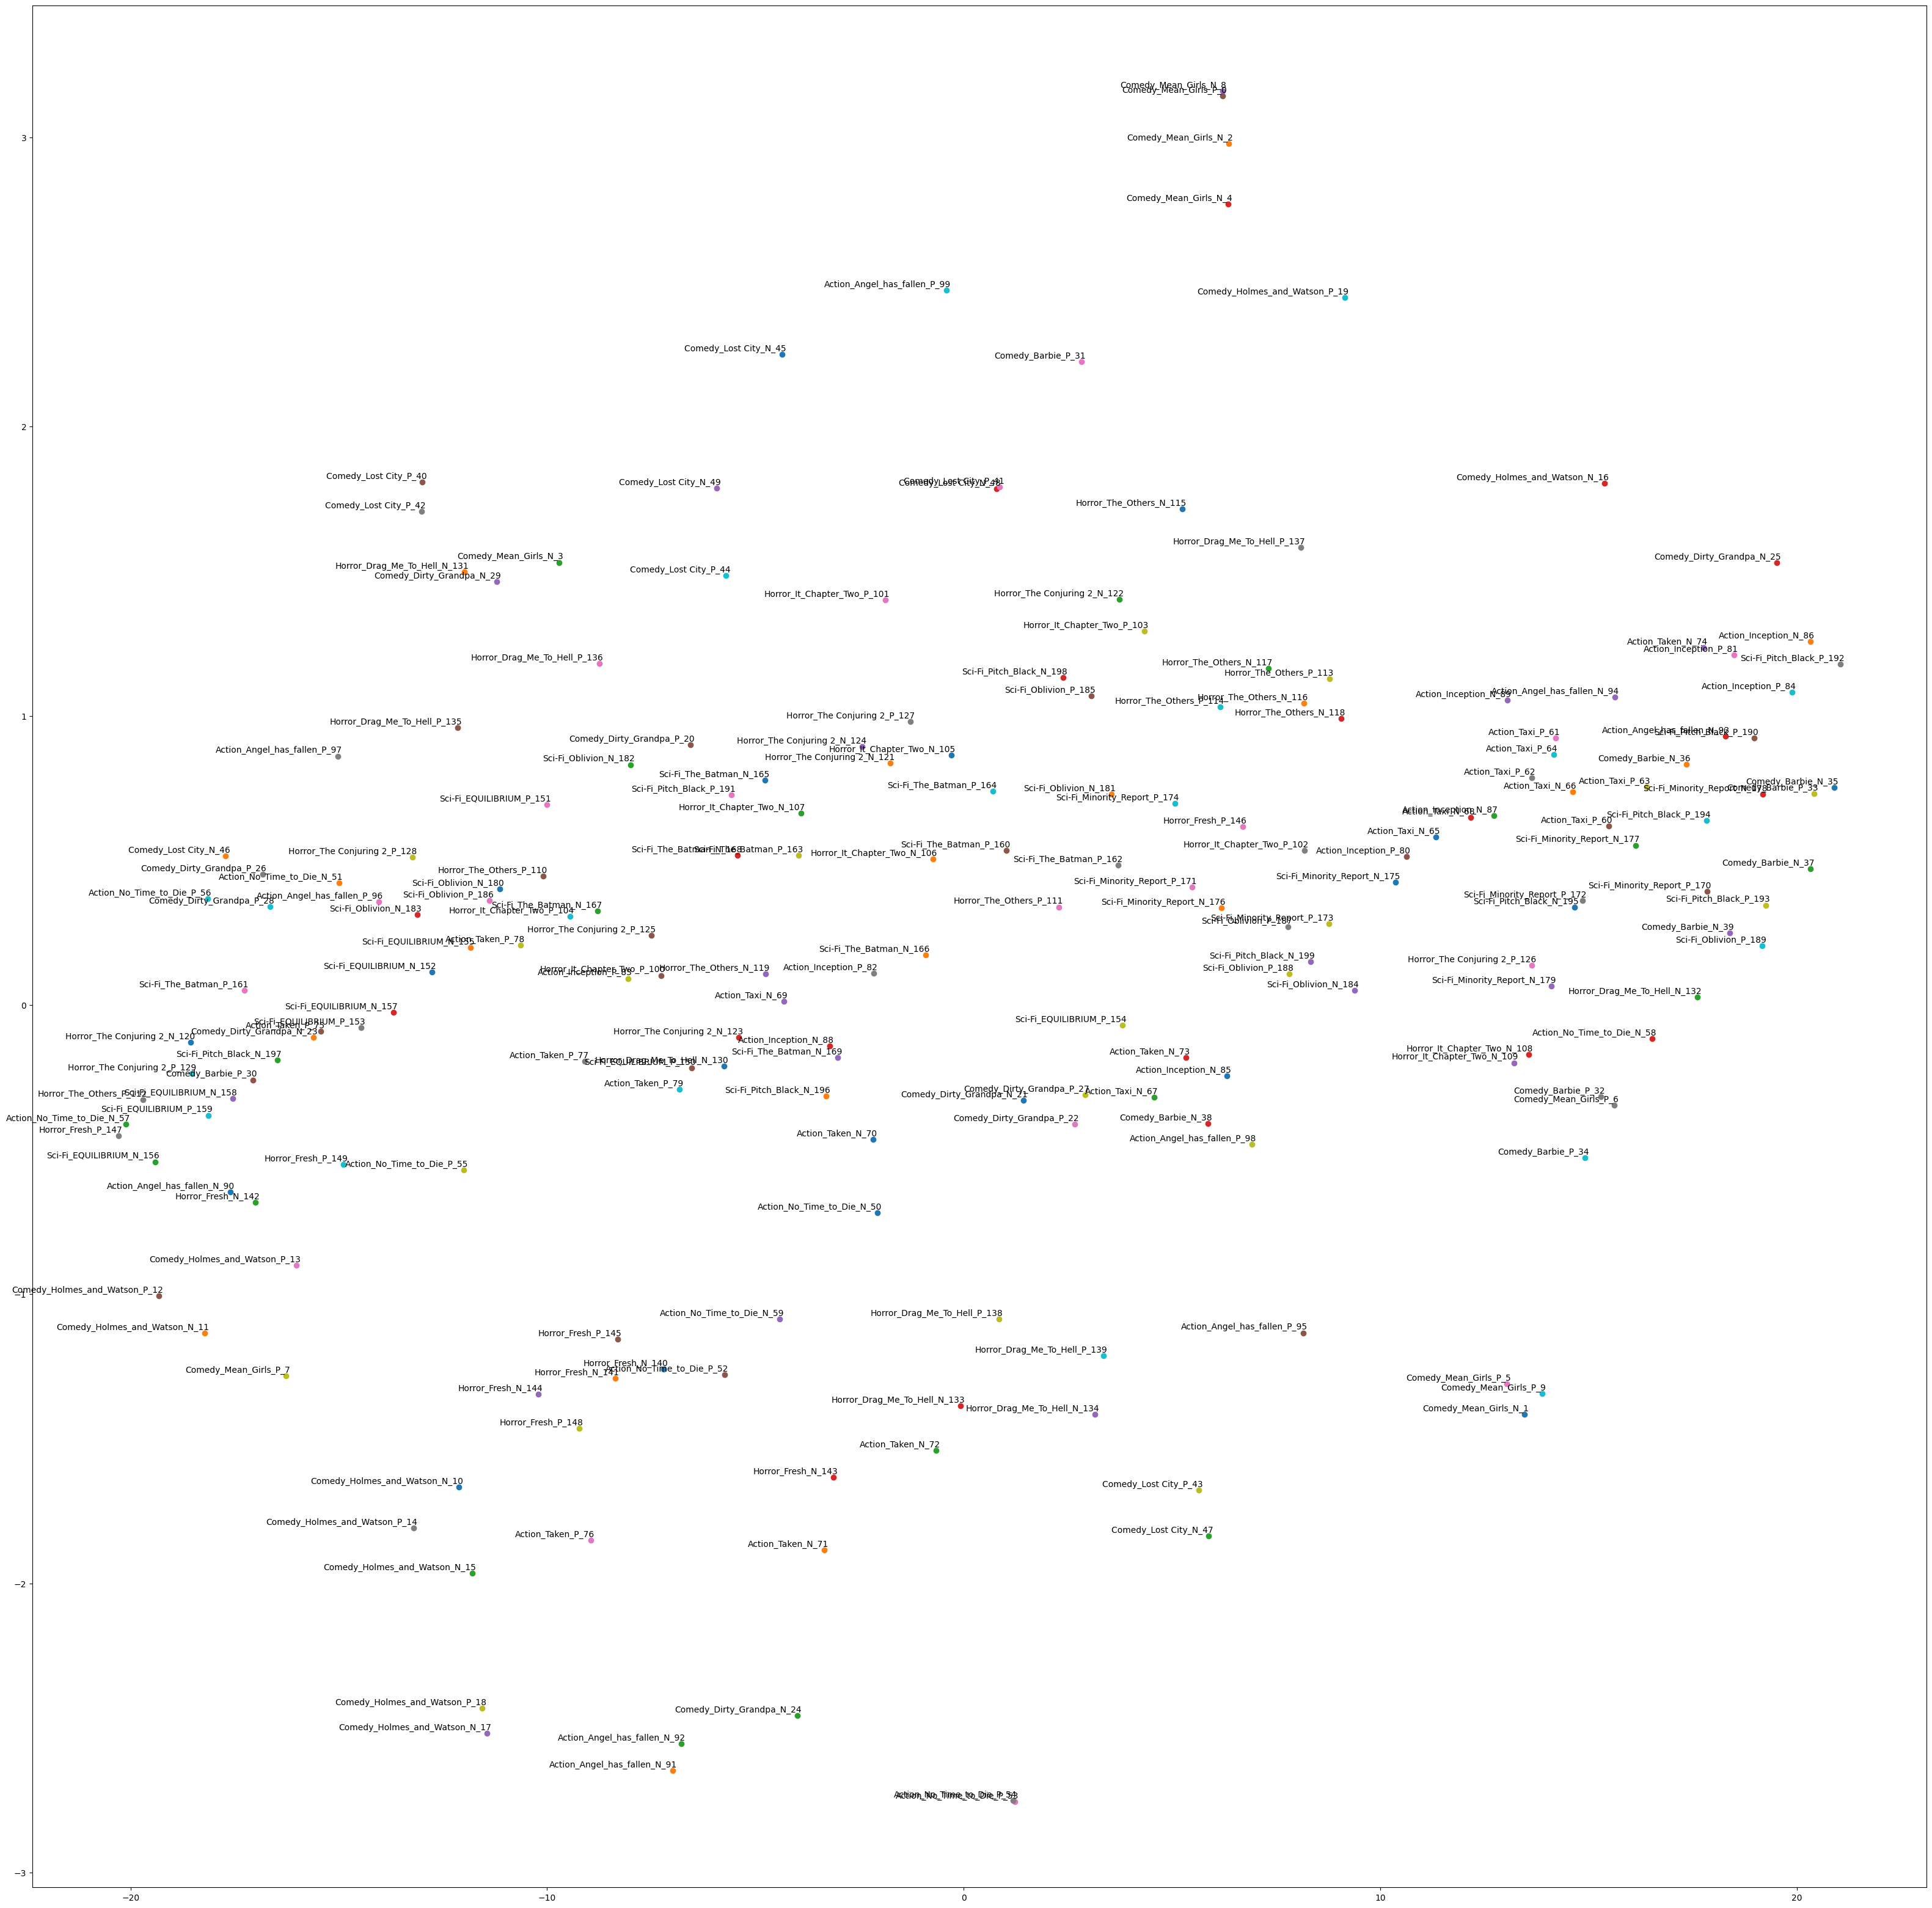

In [36]:
run_doc2vec_experiment(documents, clean_method, 100, 'Doc2Vec_exp')

# Part 1

In [37]:
import pandas as pd

columns = corpus_df.columns
columns

Index(['DSI_Title', 'Text', 'Submission File Name', 'Student Name',
       'Genre of Movie', 'Review Type (pos or neg)', 'Movie Title',
       'Descriptor', 'Doc_ID'],
      dtype='object')

In [38]:
movies= corpus_df["Movie Title"].unique
corpus_df["Movie Title"] = corpus_df["Movie Title"].astype(str)

In [39]:
mean_girls_movies = corpus_df.loc[corpus_df["Movie Title"] == "Mean_Girls"]

mean_girls_movies

DSI_Title  \
Doc_ID                         
1        XOY_Doc2_Mean_Girls   
2        XOY_Doc3_Mean_Girls   
3        XOY_Doc4_Mean_Girls   
4        XOY_Doc5_Mean_Girls   
8        XOY_Doc9_Mean_Girls   
0        XOY_Doc1_Mean_Girls   
5        XOY_Doc6_Mean_Girls   
6        XOY_Doc7_Mean_Girls   
7        XOY_Doc8_Mean_Girls   
9       XOY_Doc10_Mean_Girls   

                                                     Text  \
Doc_ID                                                      
1       Although Mean Girls is likely to be frequently...   
2       She is immediately befriended by two of North ...   
3       Mean Girls '' is somewhat of a phenomenon in t...   
4       The tagline for this movie - Watch Your Back -...   
8       When 16-year-old Cady ( Lindsay Lohan ) first ...   
0       `` In a wasteland of dumb movies about teenage...   
5       Mean Girls looks and feels like a 2000s comedy...   
6       Teenage Cady Heron ( Lindsay Lohan ) was educa...   
7       Fans who found teen star Lindsay Lohan 's last...   
9       'Gretchen , stop trying to make 'fetch ' happe...   

        Submission File Name Student Name Genre of Movie  \
Doc_ID                                                     
1        XOY_Doc2_Mean_Girls          XOY         Comedy   
2        XOY_Doc3_Mean_Girls          XOY         Comedy   
3        XOY_Doc4_Mean_Girls          XOY         Comedy   
4        XOY_Doc5_Mean_Girls          XOY         Comedy   
8        XOY_Doc9_Mean_Girls          XOY         Comedy   
0        XOY_Doc1_Mean_Girls          XOY         Comedy   
5        XOY_Doc6_Mean_Girls          XOY         Comedy   
6        XOY_Doc7_Mean_Girls          XOY         Comedy   
7        XOY_Doc8_Mean_Girls          XOY         Comedy   
9       XOY_Doc10_Mean_Girls          XOY         Comedy   

       Review Type (pos or neg) Movie Title             Descriptor  Doc_ID  
Doc_ID                                                                      
1                      Negative  Mean_Girls  Comedy_Mean_Girls_N_1       1  
2                      Negative  Mean_Girls  Comedy_Mean_Girls_N_2       2  
3                      Negative  Mean_Girls  Comedy_Mean_Girls_N_3       3  
4                      Negative  Mean_Girls  Comedy_Mean_Girls_N_4       4  
8                      Negative  Mean_Girls  Comedy_Mean_Girls_N_8       8  
0                      Positive  Mean_Girls  Comedy_Mean_Girls_P_0       0  
5                      Positive  Mean_Girls  Comedy_Mean_Girls_P_5       5  
6                      Positive  Mean_Girls  Comedy_Mean_Girls_P_6       6  
7                      Positive  Mean_Girls  Comedy_Mean_Girls_P_7       7  
9                      Positive  Mean_Girls  Comedy_Mean_Girls_P_9       9

In [40]:
def normalize_document(text: str) -> str:
    text = remove_punctuation(text)
    text = text.lower()
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text


mean_girls_movies['Processed_text'] = mean_girls_movies['Text'].apply(normalize_document)



In [41]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')


mean_girls_movies['tokenized_review'] = mean_girls_movies['Processed_text'].apply(word_tokenize)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
mean_girls_movies.head()

DSI_Title  \
Doc_ID                        
1       XOY_Doc2_Mean_Girls   
2       XOY_Doc3_Mean_Girls   
3       XOY_Doc4_Mean_Girls   
4       XOY_Doc5_Mean_Girls   
8       XOY_Doc9_Mean_Girls   

                                                     Text  \
Doc_ID                                                      
1       Although Mean Girls is likely to be frequently...   
2       She is immediately befriended by two of North ...   
3       Mean Girls '' is somewhat of a phenomenon in t...   
4       The tagline for this movie - Watch Your Back -...   
8       When 16-year-old Cady ( Lindsay Lohan ) first ...   

       Submission File Name Student Name Genre of Movie  \
Doc_ID                                                    
1       XOY_Doc2_Mean_Girls          XOY         Comedy   
2       XOY_Doc3_Mean_Girls          XOY         Comedy   
3       XOY_Doc4_Mean_Girls          XOY         Comedy   
4       XOY_Doc5_Mean_Girls          XOY         Comedy   
8       XOY_Doc9_Mean_Girls          XOY         Comedy   

       Review Type (pos or neg) Movie Title             Descriptor  Doc_ID  \
Doc_ID                                                                       
1                      Negative  Mean_Girls  Comedy_Mean_Girls_N_1       1   
2                      Negative  Mean_Girls  Comedy_Mean_Girls_N_2       2   
3                      Negative  Mean_Girls  Comedy_Mean_Girls_N_3       3   
4                      Negative  Mean_Girls  Comedy_Mean_Girls_N_4       4   
8                      Negative  Mean_Girls  Comedy_Mean_Girls_N_8       8   

                                           Processed_text  \
Doc_ID                                                      
1       although mean girls is likely to be frequently...   
2       she is immediately befriended by two of north ...   
3       mean girls is somewhat of a phenomenon in the ...   
4       the tagline for this movie watch your back rem...   
8       when year old cady lindsay lohan first arrives...   

                                         tokenized_review  
Doc_ID                                                     
1       [although, mean, girls, is, likely, to, be, fr...  
2       [she, is, immediately, befriended, by, two, of...  
3       [mean, girls, is, somewhat, of, a, phenomenon,...  
4       [the, tagline, for, this, movie, watch, your, ...  
8       [when, year, old, cady, lindsay, lohan, first,...

In [87]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)


mean_girls_movies['lemmatized_tokens'] = mean_girls_movies['tokenized_review'].apply(lemmatize)
mean_girls_movies.head()

DSI_Title  \
Doc_ID                        
1       XOY_Doc2_Mean_Girls   
2       XOY_Doc3_Mean_Girls   
3       XOY_Doc4_Mean_Girls   
4       XOY_Doc5_Mean_Girls   
8       XOY_Doc9_Mean_Girls   

                                                     Text  \
Doc_ID                                                      
1       Although Mean Girls is likely to be frequently...   
2       She is immediately befriended by two of North ...   
3       Mean Girls '' is somewhat of a phenomenon in t...   
4       The tagline for this movie - Watch Your Back -...   
8       When 16-year-old Cady ( Lindsay Lohan ) first ...   

       Submission File Name Student Name Genre of Movie  \
Doc_ID                                                    
1       XOY_Doc2_Mean_Girls          XOY         Comedy   
2       XOY_Doc3_Mean_Girls          XOY         Comedy   
3       XOY_Doc4_Mean_Girls          XOY         Comedy   
4       XOY_Doc5_Mean_Girls          XOY         Comedy   
8       XOY_Doc9_Mean_Girls          XOY         Comedy   

       Review Type (pos or neg) Movie Title             Descriptor  Doc_ID  \
Doc_ID                                                                       
1                      Negative  Mean_Girls  Comedy_Mean_Girls_N_1       1   
2                      Negative  Mean_Girls  Comedy_Mean_Girls_N_2       2   
3                      Negative  Mean_Girls  Comedy_Mean_Girls_N_3       3   
4                      Negative  Mean_Girls  Comedy_Mean_Girls_N_4       4   
8                      Negative  Mean_Girls  Comedy_Mean_Girls_N_8       8   

                                           Processed_text  \
Doc_ID                                                      
1       although mean girls is likely to be frequently...   
2       she is immediately befriended by two of north ...   
3       mean girls is somewhat of a phenomenon in the ...   
4       the tagline for this movie watch your back rem...   
8       when year old cady lindsay lohan first arrives...   

                                         tokenized_review  \
Doc_ID                                                      
1       [although, mean, girls, is, likely, to, be, fr...   
2       [she, is, immediately, befriended, by, two, of...   
3       [mean, girls, is, somewhat, of, a, phenomenon,...   
4       [the, tagline, for, this, movie, watch, your, ...   
8       [when, year, old, cady, lindsay, lohan, first,...   

                                        lemmatized_tokens  
Doc_ID                                                     
1       [although, mean, girl, is, likely, to, be, fre...  
2       [she, is, immediately, befriended, by, two, of...  
3       [mean, girl, is, somewhat, of, a, phenomenon, ...  
4       [the, tagline, for, this, movie, watch, your, ...  
8       [when, year, old, cady, lindsay, lohan, first,...

In [44]:
mean_girls_movies.head()

DSI_Title  \
Doc_ID                        
1       XOY_Doc2_Mean_Girls   
2       XOY_Doc3_Mean_Girls   
3       XOY_Doc4_Mean_Girls   
4       XOY_Doc5_Mean_Girls   
8       XOY_Doc9_Mean_Girls   

                                                     Text  \
Doc_ID                                                      
1       Although Mean Girls is likely to be frequently...   
2       She is immediately befriended by two of North ...   
3       Mean Girls '' is somewhat of a phenomenon in t...   
4       The tagline for this movie - Watch Your Back -...   
8       When 16-year-old Cady ( Lindsay Lohan ) first ...   

       Submission File Name Student Name Genre of Movie  \
Doc_ID                                                    
1       XOY_Doc2_Mean_Girls          XOY         Comedy   
2       XOY_Doc3_Mean_Girls          XOY         Comedy   
3       XOY_Doc4_Mean_Girls          XOY         Comedy   
4       XOY_Doc5_Mean_Girls          XOY         Comedy   
8       XOY_Doc9_Mean_Girls          XOY         Comedy   

       Review Type (pos or neg) Movie Title             Descriptor  Doc_ID  \
Doc_ID                                                                       
1                      Negative  Mean_Girls  Comedy_Mean_Girls_N_1       1   
2                      Negative  Mean_Girls  Comedy_Mean_Girls_N_2       2   
3                      Negative  Mean_Girls  Comedy_Mean_Girls_N_3       3   
4                      Negative  Mean_Girls  Comedy_Mean_Girls_N_4       4   
8                      Negative  Mean_Girls  Comedy_Mean_Girls_N_8       8   

                                           Processed_text  \
Doc_ID                                                      
1       although mean girls is likely to be frequently...   
2       she is immediately befriended by two of north ...   
3       mean girls is somewhat of a phenomenon in the ...   
4       the tagline for this movie watch your back rem...   
8       when year old cady lindsay lohan first arrives...   

                                         tokenized_review  
Doc_ID                                                     
1       [although, mean, girls, is, likely, to, be, fr...  
2       [she, is, immediately, befriended, by, two, of...  
3       [mean, girls, is, somewhat, of, a, phenomenon,...  
4       [the, tagline, for, this, movie, watch, your, ...  
8       [when, year, old, cady, lindsay, lohan, first,...

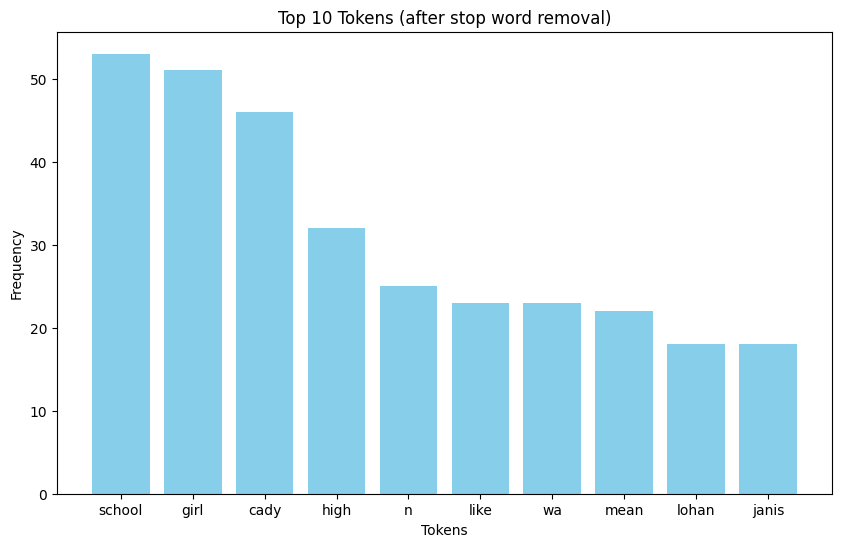

In [89]:
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords

mean_girls_movies['lemmatized_text'] = mean_girls_movies['lemmatized_tokens'].apply(join_tokens)

# Remove stop words
stop_words = set(stopwords.words('english'))
mean_girls_movies['lemmatized_text'] = mean_girls_movies['lemmatized_text'].apply(lambda text: ' '.join([word for word in text.split() if word.lower() not in stop_words]))


all_tokens = ' '.join(mean_girls_movies['lemmatized_text']).split()
token_counts = Counter(all_tokens)


top_tokens = token_counts.most_common(10)


tokens, counts = zip(*top_tokens)


plt.figure(figsize=(10, 6))
plt.bar(tokens, counts, color='skyblue')
plt.title('Top 10 Tokens (after stop word removal)')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.show()


# Part 2

In [56]:
def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_punctuation(input_text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text

STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    '''
    Tokenization involves the following steps:
    1. Break text down to tokens (i.e., words separated by white spaces)
    2. Remove stop words from the tokens generated in step 1
    '''
    tokens = nltk.word_tokenize(text)
    tokenized_text = remove_stop_words(tokens)

    return tokenized_text
def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]
corpus_df.head()

DSI_Title  \
Doc_ID                              
90      LKP_Doc1_Angel_has_fallen   
91      LKP_Doc2_Angel_has_fallen   
92      LKP_Doc3_Angel_has_fallen   
93      LKP_Doc4_Angel_has_fallen   
94      LKP_Doc5_Angel_has_fallen   

                                                     Text  \
Doc_ID                                                      
90      Target is on the move . '' Heavily outnumbered...   
91      The sleepy , dopey action bonanza `` Angel Has...   
92      `` Angel Has Fallen '' marks the third time th...   
93      Improving through blandness . So Mike Banning ...   
94      This review may contain spoilers . Angel Has F...   

             Submission File Name Student Name Genre of Movie  \
Doc_ID                                                          
90      LKP_Doc1_Angel_has_fallen          LKP         Action   
91      LKP_Doc2_Angel_has_fallen          LKP         Action   
92      LKP_Doc3_Angel_has_fallen          LKP         Action   
93      LKP_Doc4_Angel_has_fallen          LKP         Action   
94      LKP_Doc5_Angel_has_fallen          LKP         Action   

       Review Type (pos or neg)       Movie Title  \
Doc_ID                                              
90                     Negative  Angel_has_fallen   
91                     Negative  Angel_has_fallen   
92                     Negative  Angel_has_fallen   
93                     Negative  Angel_has_fallen   
94                     Negative  Angel_has_fallen   

                          Descriptor  Doc_ID  \
Doc_ID                                         
90      Action_Angel_has_fallen_N_90      90   
91      Action_Angel_has_fallen_N_91      91   
92      Action_Angel_has_fallen_N_92      92   
93      Action_Angel_has_fallen_N_93      93   
94      Action_Angel_has_fallen_N_94      94   

                                           Processed_text  \
Doc_ID                                                      
90      target is on the move heavily outnumbered and ...   
91      the sleepy dopey action bonanza angel has fall...   
92       angel has fallen marks the third time that ge...   
93      improving through blandness so mike banning ge...   
94      this review may contain spoilers angel has fal...   

                                         tokenized_review  \
Doc_ID                                                      
90      <__main__.TokenizedDocument object at 0x7d18d6...   
91      <__main__.TokenizedDocument object at 0x7d18d6...   
92      <__main__.TokenizedDocument object at 0x7d18d7...   
93      <__main__.TokenizedDocument object at 0x7d18d7...   
94      <__main__.TokenizedDocument object at 0x7d18d7...   

                                        lemmatized_tokens  
Doc_ID                                                     
90      [target, is, on, the, move, heavily, outnumber...  
91      [the, sleepy, dopey, action, bonanza, angel, h...  
92      [angel, ha, fallen, mark, the, third, time, th...  
93      [improving, through, blandness, so, mike, bann...  
94      [this, review, may, contain, spoiler, angel, h...

In [60]:
corpus_df['Processed_text'] = corpus_df['Text'].apply(normalize)
corpus_df.head()

DSI_Title  \
Doc_ID                              
90      LKP_Doc1_Angel_has_fallen   
91      LKP_Doc2_Angel_has_fallen   
92      LKP_Doc3_Angel_has_fallen   
93      LKP_Doc4_Angel_has_fallen   
94      LKP_Doc5_Angel_has_fallen   

                                                     Text  \
Doc_ID                                                      
90      Target is on the move . '' Heavily outnumbered...   
91      The sleepy , dopey action bonanza `` Angel Has...   
92      `` Angel Has Fallen '' marks the third time th...   
93      Improving through blandness . So Mike Banning ...   
94      This review may contain spoilers . Angel Has F...   

             Submission File Name Student Name Genre of Movie  \
Doc_ID                                                          
90      LKP_Doc1_Angel_has_fallen          LKP         Action   
91      LKP_Doc2_Angel_has_fallen          LKP         Action   
92      LKP_Doc3_Angel_has_fallen          LKP         Action   
93      LKP_Doc4_Angel_has_fallen          LKP         Action   
94      LKP_Doc5_Angel_has_fallen          LKP         Action   

       Review Type (pos or neg)       Movie Title  \
Doc_ID                                              
90                     Negative  Angel_has_fallen   
91                     Negative  Angel_has_fallen   
92                     Negative  Angel_has_fallen   
93                     Negative  Angel_has_fallen   
94                     Negative  Angel_has_fallen   

                          Descriptor  Doc_ID  \
Doc_ID                                         
90      Action_Angel_has_fallen_N_90      90   
91      Action_Angel_has_fallen_N_91      91   
92      Action_Angel_has_fallen_N_92      92   
93      Action_Angel_has_fallen_N_93      93   
94      Action_Angel_has_fallen_N_94      94   

                                           Processed_text  \
Doc_ID                                                      
90      target is on the move heavily outnumbered and ...   
91      the sleepy dopey action bonanza angel has fall...   
92       angel has fallen marks the third time that ge...   
93      improving through blandness so mike banning ge...   
94      this review may contain spoilers angel has fal...   

                                         tokenized_review  \
Doc_ID                                                      
90      <__main__.TokenizedDocument object at 0x7d18d6...   
91      <__main__.TokenizedDocument object at 0x7d18d6...   
92      <__main__.TokenizedDocument object at 0x7d18d7...   
93      <__main__.TokenizedDocument object at 0x7d18d7...   
94      <__main__.TokenizedDocument object at 0x7d18d7...   

                                        lemmatized_tokens  
Doc_ID                                                     
90      [target, is, on, the, move, heavily, outnumber...  
91      [the, sleepy, dopey, action, bonanza, angel, h...  
92      [angel, ha, fallen, mark, the, third, time, th...  
93      [improving, through, blandness, so, mike, bann...  
94      [this, review, may, contain, spoiler, angel, h...

In [63]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')  # Download the punkt tokenizer
nltk.download('stopwords')  # Download the stopwords dataset

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


corpus_df['tokenized_review'] = corpus_df['Processed_text'].apply(tokenize)
stop_words = set(stopwords.words('english'))
corpus_df['tokenized_review'] = corpus_df['tokenized_review'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

corpus_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


DSI_Title  \
Doc_ID                              
90      LKP_Doc1_Angel_has_fallen   
91      LKP_Doc2_Angel_has_fallen   
92      LKP_Doc3_Angel_has_fallen   
93      LKP_Doc4_Angel_has_fallen   
94      LKP_Doc5_Angel_has_fallen   

                                                     Text  \
Doc_ID                                                      
90      Target is on the move . '' Heavily outnumbered...   
91      The sleepy , dopey action bonanza `` Angel Has...   
92      `` Angel Has Fallen '' marks the third time th...   
93      Improving through blandness . So Mike Banning ...   
94      This review may contain spoilers . Angel Has F...   

             Submission File Name Student Name Genre of Movie  \
Doc_ID                                                          
90      LKP_Doc1_Angel_has_fallen          LKP         Action   
91      LKP_Doc2_Angel_has_fallen          LKP         Action   
92      LKP_Doc3_Angel_has_fallen          LKP         Action   
93      LKP_Doc4_Angel_has_fallen          LKP         Action   
94      LKP_Doc5_Angel_has_fallen          LKP         Action   

       Review Type (pos or neg)       Movie Title  \
Doc_ID                                              
90                     Negative  Angel_has_fallen   
91                     Negative  Angel_has_fallen   
92                     Negative  Angel_has_fallen   
93                     Negative  Angel_has_fallen   
94                     Negative  Angel_has_fallen   

                          Descriptor  Doc_ID  \
Doc_ID                                         
90      Action_Angel_has_fallen_N_90      90   
91      Action_Angel_has_fallen_N_91      91   
92      Action_Angel_has_fallen_N_92      92   
93      Action_Angel_has_fallen_N_93      93   
94      Action_Angel_has_fallen_N_94      94   

                                           Processed_text  \
Doc_ID                                                      
90      target is on the move heavily outnumbered and ...   
91      the sleepy dopey action bonanza angel has fall...   
92       angel has fallen marks the third time that ge...   
93      improving through blandness so mike banning ge...   
94      this review may contain spoilers angel has fal...   

                                         tokenized_review  \
Doc_ID                                                      
90      [target, move, heavily, outnumbered, outgunned...   
91      [sleepy, dopey, action, bonanza, angel, fallen...   
92      [angel, fallen, marks, third, time, gerard, bu...   
93      [improving, blandness, mike, banning, gerard, ...   
94      [review, may, contain, spoilers, angel, fallen...   

                                        lemmatized_tokens  
Doc_ID                                                     
90      [t, a, r, g, e, t,  , m, o, v, e,  , h, e, a, ...  
91      [s, l, e, e, p, y,  , d, o, p, e, y,  , a, c, ...  
92      [a, n, g, e, l,  , f, a, l, l, e, n,  , m, a, ...  
93      [i, m, p, r, o, v, i, n, g,  , b, l, a, n, d, ...  
94      [r, e, v, i, e, w,  , m, a, y,  , c, o, n, t, ...

In [67]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)


corpus_df['lemmatized_tokens'] = corpus_df['tokenized_review'].apply(lemmatize)
corpus_df.head()

DSI_Title  \
Doc_ID                              
90      LKP_Doc1_Angel_has_fallen   
91      LKP_Doc2_Angel_has_fallen   
92      LKP_Doc3_Angel_has_fallen   
93      LKP_Doc4_Angel_has_fallen   
94      LKP_Doc5_Angel_has_fallen   

                                                     Text  \
Doc_ID                                                      
90      Target is on the move . '' Heavily outnumbered...   
91      The sleepy , dopey action bonanza `` Angel Has...   
92      `` Angel Has Fallen '' marks the third time th...   
93      Improving through blandness . So Mike Banning ...   
94      This review may contain spoilers . Angel Has F...   

             Submission File Name Student Name Genre of Movie  \
Doc_ID                                                          
90      LKP_Doc1_Angel_has_fallen          LKP         Action   
91      LKP_Doc2_Angel_has_fallen          LKP         Action   
92      LKP_Doc3_Angel_has_fallen          LKP         Action   
93      LKP_Doc4_Angel_has_fallen          LKP         Action   
94      LKP_Doc5_Angel_has_fallen          LKP         Action   

       Review Type (pos or neg)       Movie Title  \
Doc_ID                                              
90                     Negative  Angel_has_fallen   
91                     Negative  Angel_has_fallen   
92                     Negative  Angel_has_fallen   
93                     Negative  Angel_has_fallen   
94                     Negative  Angel_has_fallen   

                          Descriptor  Doc_ID  \
Doc_ID                                         
90      Action_Angel_has_fallen_N_90      90   
91      Action_Angel_has_fallen_N_91      91   
92      Action_Angel_has_fallen_N_92      92   
93      Action_Angel_has_fallen_N_93      93   
94      Action_Angel_has_fallen_N_94      94   

                                           Processed_text  \
Doc_ID                                                      
90      target is on the move heavily outnumbered and ...   
91      the sleepy dopey action bonanza angel has fall...   
92       angel has fallen marks the third time that ge...   
93      improving through blandness so mike banning ge...   
94      this review may contain spoilers angel has fal...   

                                         tokenized_review  \
Doc_ID                                                      
90      [target, move, heavily, outnumbered, outgunned...   
91      [sleepy, dopey, action, bonanza, angel, fallen...   
92      [angel, fallen, marks, third, time, gerard, bu...   
93      [improving, blandness, mike, banning, gerard, ...   
94      [review, may, contain, spoilers, angel, fallen...   

                                        lemmatized_tokens  
Doc_ID                                                     
90      [target, move, heavily, outnumbered, outgunned...  
91      [sleepy, dopey, action, bonanza, angel, fallen...  
92      [angel, fallen, mark, third, time, gerard, but...  
93      [improving, blandness, mike, banning, gerard, ...  
94      [review, may, contain, spoiler, angel, fallen,...

In [68]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)
corpus_df['lemmatized_text'] = corpus_df['lemmatized_tokens'].apply(join_tokens)
corpus_df.head()

DSI_Title  \
Doc_ID                              
90      LKP_Doc1_Angel_has_fallen   
91      LKP_Doc2_Angel_has_fallen   
92      LKP_Doc3_Angel_has_fallen   
93      LKP_Doc4_Angel_has_fallen   
94      LKP_Doc5_Angel_has_fallen   

                                                     Text  \
Doc_ID                                                      
90      Target is on the move . '' Heavily outnumbered...   
91      The sleepy , dopey action bonanza `` Angel Has...   
92      `` Angel Has Fallen '' marks the third time th...   
93      Improving through blandness . So Mike Banning ...   
94      This review may contain spoilers . Angel Has F...   

             Submission File Name Student Name Genre of Movie  \
Doc_ID                                                          
90      LKP_Doc1_Angel_has_fallen          LKP         Action   
91      LKP_Doc2_Angel_has_fallen          LKP         Action   
92      LKP_Doc3_Angel_has_fallen          LKP         Action   
93      LKP_Doc4_Angel_has_fallen          LKP         Action   
94      LKP_Doc5_Angel_has_fallen          LKP         Action   

       Review Type (pos or neg)       Movie Title  \
Doc_ID                                              
90                     Negative  Angel_has_fallen   
91                     Negative  Angel_has_fallen   
92                     Negative  Angel_has_fallen   
93                     Negative  Angel_has_fallen   
94                     Negative  Angel_has_fallen   

                          Descriptor  Doc_ID  \
Doc_ID                                         
90      Action_Angel_has_fallen_N_90      90   
91      Action_Angel_has_fallen_N_91      91   
92      Action_Angel_has_fallen_N_92      92   
93      Action_Angel_has_fallen_N_93      93   
94      Action_Angel_has_fallen_N_94      94   

                                           Processed_text  \
Doc_ID                                                      
90      target is on the move heavily outnumbered and ...   
91      the sleepy dopey action bonanza angel has fall...   
92       angel has fallen marks the third time that ge...   
93      improving through blandness so mike banning ge...   
94      this review may contain spoilers angel has fal...   

                                         tokenized_review  \
Doc_ID                                                      
90      [target, move, heavily, outnumbered, outgunned...   
91      [sleepy, dopey, action, bonanza, angel, fallen...   
92      [angel, fallen, marks, third, time, gerard, bu...   
93      [improving, blandness, mike, banning, gerard, ...   
94      [review, may, contain, spoilers, angel, fallen...   

                                        lemmatized_tokens  \
Doc_ID                                                      
90      [target, move, heavily, outnumbered, outgunned...   
91      [sleepy, dopey, action, bonanza, angel, fallen...   
92      [angel, fallen, mark, third, time, gerard, but...   
93      [improving, blandness, mike, banning, gerard, ...   
94      [review, may, contain, spoiler, angel, fallen,...   

                                          lemmatized_text  
Doc_ID                                                     
90      target move heavily outnumbered outgunned mike...  
91      sleepy dopey action bonanza angel fallen disap...  
92      angel fallen mark third time gerard butler sec...  
93      improving blandness mike banning gerard butler...  
94      review may contain spoiler angel fallen third ...

In [69]:
count_vectorizer = CountVectorizer()
dtm_class_corpus = count_vectorizer.fit_transform(corpus_df['lemmatized_text'])
word_counts_class_corpus = pd.DataFrame(dtm_class_corpus.toarray(),
                                        columns=count_vectorizer.get_feature_names_out(),
                                        index=corpus_df.index)
word_counts_class_corpus.head()

aack  aaron  abandon  abandoned  abduct  abducted  abducting  \
Doc_ID                                                                 
90         0      0        0          0       0         0          0   
91         0      0        0          0       0         0          0   
92         0      1        0          0       0         0          0   
93         0      0        0          0       0         0          0   
94         0      0        0          0       0         0          0   

        abetting  abigail  ability  ...  zinger  zip  zodiac  zoe  zoetrope  \
Doc_ID                              ...                                       
90             0        0        1  ...       0    0       0    0         0   
91             0        0        0  ...       0    0       0    0         0   
92             0        0        0  ...       0    0       0    0         0   
93             0        0        0  ...       0    0       0    0         0   
94             0        0        0  ...       0    0       0    0         0   

        zoey  zombie  zone  zoologist  zooming  
Doc_ID                                          
90         0       0     0          0        0  
91         0       0     0          0        0  
92         0       0     0          0        0  
93         0       0     0          0        0  
94         0       0     0          0        0  

[5 rows x 10079 columns]

In [70]:
(word_counts_class_corpus.sum()
                         .sort_values(ascending=False)
                         .head(25))

film         554
movie        449
like         311
one          306
time         239
character    193
even         174
get          160
make         156
year         142
story        139
would        137
action       136
also         134
well         131
two          129
good         127
way          121
first        119
much         117
world        109
know         106
go           102
take         102
come         101
dtype: int64

In [71]:
tfidf_vectorizer = TfidfVectorizer()
dtm_class_corpus = tfidf_vectorizer.fit_transform(corpus_df['lemmatized_text'])
tfidf_scores_class_corpus = pd.DataFrame(dtm_class_corpus.toarray(),
                                         columns=tfidf_vectorizer.get_feature_names_out(),
                                         index=corpus_df.index)
tfidf_scores_class_corpus.head()

aack  aaron  abandon  abandoned  abduct  abducted  abducting  \
Doc_ID                                                                 
90      0.00   0.00     0.00       0.00    0.00      0.00       0.00   
91      0.00   0.00     0.00       0.00    0.00      0.00       0.00   
92      0.00   0.06     0.00       0.00    0.00      0.00       0.00   
93      0.00   0.00     0.00       0.00    0.00      0.00       0.00   
94      0.00   0.00     0.00       0.00    0.00      0.00       0.00   

        abetting  abigail  ability  ...  zinger  zip  zodiac  zoe  zoetrope  \
Doc_ID                              ...                                       
90          0.00     0.00     0.05  ...    0.00 0.00    0.00 0.00      0.00   
91          0.00     0.00     0.00  ...    0.00 0.00    0.00 0.00      0.00   
92          0.00     0.00     0.00  ...    0.00 0.00    0.00 0.00      0.00   
93          0.00     0.00     0.00  ...    0.00 0.00    0.00 0.00      0.00   
94          0.00     0.00     0.00  ...    0.00 0.00    0.00 0.00      0.00   

        zoey  zombie  zone  zoologist  zooming  
Doc_ID                                          
90      0.00    0.00  0.00       0.00     0.00  
91      0.00    0.00  0.00       0.00     0.00  
92      0.00    0.00  0.00       0.00     0.00  
93      0.00    0.00  0.00       0.00     0.00  
94      0.00    0.00  0.00       0.00     0.00  

[5 rows x 10079 columns]

In [72]:
(tfidf_scores_class_corpus.mean()
                          .sort_values(ascending=False)
                          .head(10))

film        0.05
movie       0.04
like        0.03
one         0.03
time        0.02
character   0.02
bond        0.02
get         0.02
action      0.02
even        0.02
dtype: float64

In [73]:
similarities = cosine_similarity(tfidf_scores_class_corpus,
                                 tfidf_scores_class_corpus)

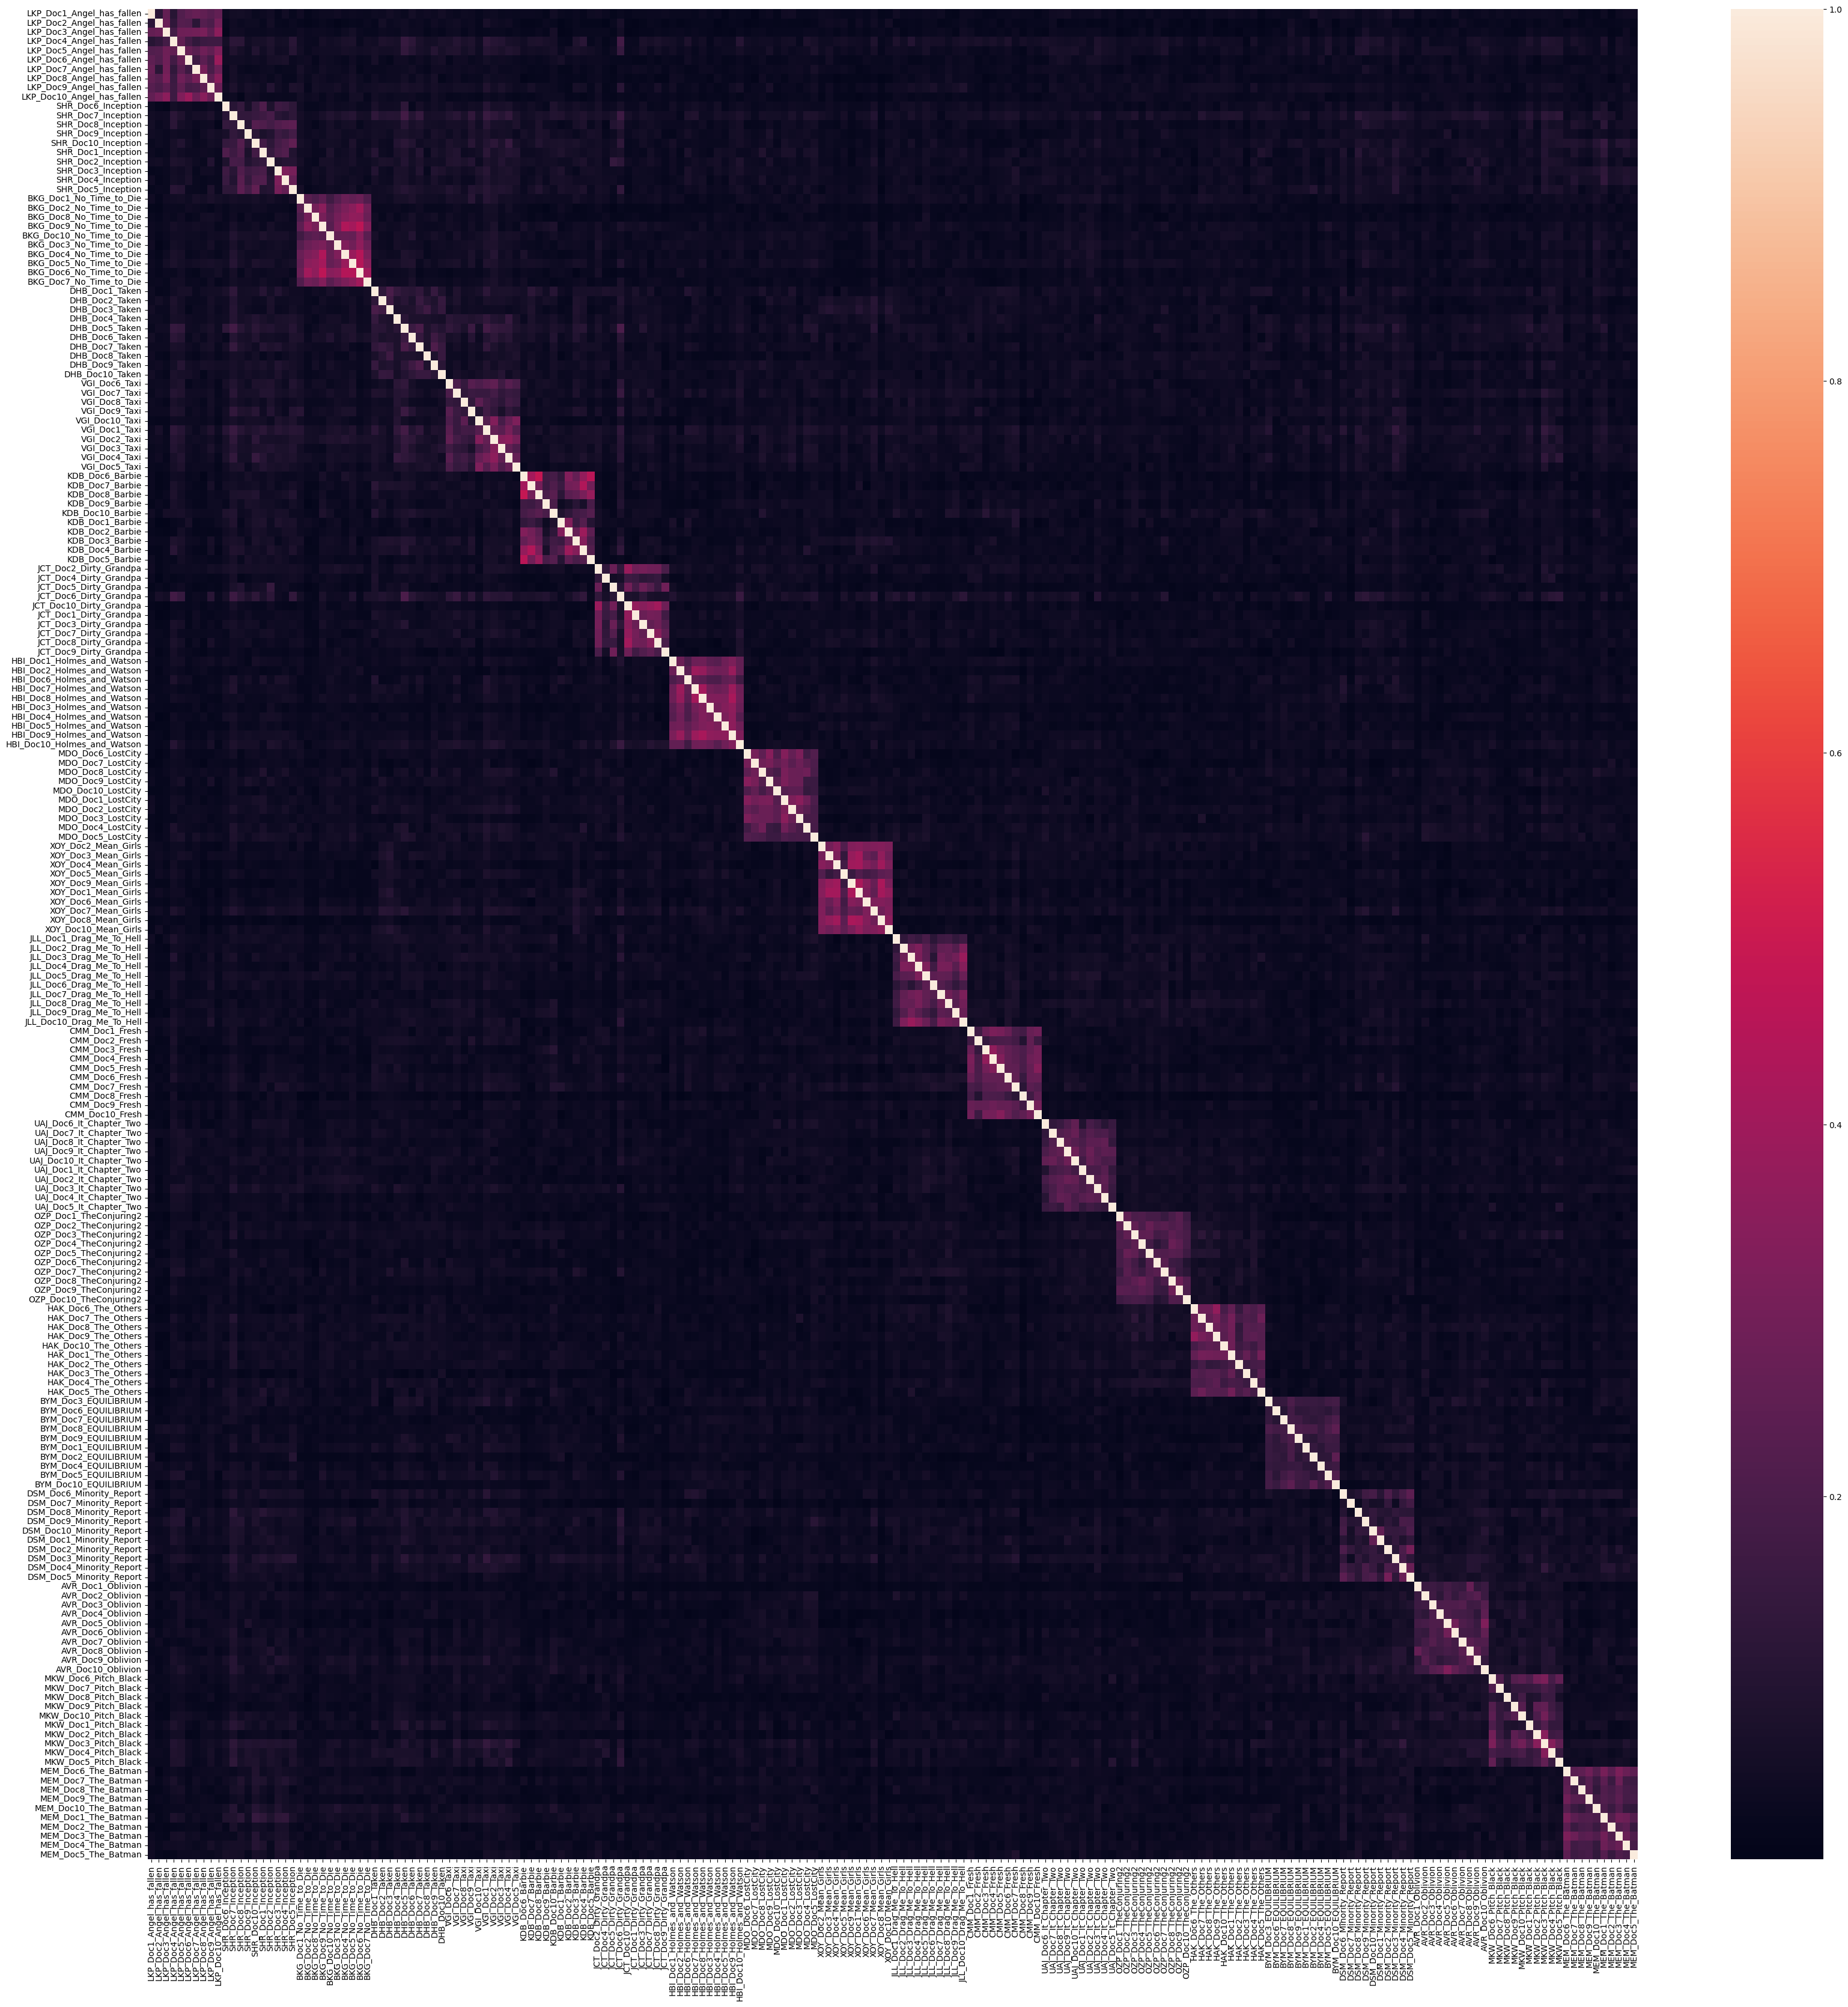

In [75]:
fig, ax = plt.subplots(figsize=(40, 40))

sns.heatmap(ax=ax,
            data=similarities,
            xticklabels=corpus_df.DSI_Title,
            yticklabels=corpus_df.DSI_Title);

In [76]:
top100_tokens_tfidf = (tfidf_scores_class_corpus.mean()
                                                .sort_values(ascending=False)
                                                .head(100)
                                                .index)
top100_tokens_tfidf

Index(['film', 'movie', 'like', 'one', 'time', 'character', 'bond', 'get',
       'action', 'even', 'make', 'barbie', 'story', 'two', 'girl', 'year',
       'good', 'would', 'well', 'batman', 'holmes', 'woman', 'also', 'horror',
       'world', 'much', 'way', 'first', 'know', 'old', 'really', 'many',
       'feel', 'come', 'scene', 'school', 'go', 'comedy', 'see', 'take',
       'could', 'house', 'thing', 'life', 'say', 'people', 'still', 'new',
       'plot', 'noa', 'high', 'back', 'cady', 'set', 'director', 'work',
       'never', 'something', 'man', 'made', 'every', 'long', 'book', 'watson',
       'day', 'going', 'look', 'child', 'want', 'fallen', 'best', 'played',
       'daughter', 'mean', 'great', 'car', 'play', 'james', 'big', 'friend',
       'nolan', 'find', 'around', 'seen', 'real', 'young', 'die', 'raimi',
       'john', 'audience', 'bad', 'dream', 'hell', 'mike', 'tell', 'jack',
       'left', 'human', 'end', 'may'],
      dtype='object')

In [78]:
model_word2vec = Word2Vec(sentences=corpus_df.lemmatized_tokens,
                          min_count=1,
                          window=5)

In [79]:
model_word2vec.wv['film']

array([-0.20943724,  0.34756732,  0.04987775,  0.06363516,  0.00673987,
       -0.37081936,  0.10832921,  0.6088977 , -0.17507152, -0.11885229,
       -0.15539974, -0.4263549 , -0.1606837 ,  0.1180656 ,  0.13340111,
       -0.35890123,  0.12519415, -0.3180602 , -0.00516024, -0.5078342 ,
        0.20623924,  0.14974542,  0.3232089 , -0.13855235,  0.05846778,
       -0.09487353, -0.27756462, -0.12811367, -0.28849322,  0.02624447,
        0.31341612,  0.04243538,  0.0552032 , -0.11105248, -0.14379609,
        0.2657706 ,  0.12160508, -0.21695934, -0.08660507, -0.54523075,
        0.01787887, -0.24143627, -0.10215975, -0.0059066 ,  0.16555713,
       -0.07342947, -0.2463782 ,  0.02241571,  0.11799684,  0.26532534,
        0.11020391, -0.19620103, -0.10834702, -0.11122595, -0.22037782,
        0.2506732 ,  0.25340962, -0.05175885, -0.13590588,  0.07975139,
        0.11833154,  0.1292835 , -0.03107373, -0.04486581, -0.28364778,
        0.21828398,  0.01925793,  0.16770852, -0.2366065 ,  0.31

In [80]:
top100_tokens_tfidf_vectors = {token: model_word2vec.wv[token]
                               for token in top100_tokens_tfidf}
top100_tfidf_word_vectors = (pd.DataFrame(top100_tokens_tfidf_vectors)
                               .transpose())
top100_tfidf_word_vectors

0    1    2    3    4     5    6    7     8     9   ...   90   91  \
film  -0.21 0.35 0.05 0.06 0.01 -0.37 0.11 0.61 -0.18 -0.12  ... 0.24 0.10   
movie -0.20 0.33 0.05 0.05 0.02 -0.34 0.09 0.56 -0.16 -0.11  ... 0.22 0.09   
like  -0.18 0.29 0.04 0.04 0.02 -0.30 0.08 0.49 -0.13 -0.10  ... 0.18 0.08   
one   -0.17 0.27 0.03 0.04 0.02 -0.28 0.08 0.47 -0.14 -0.08  ... 0.19 0.07   
time  -0.16 0.25 0.03 0.03 0.00 -0.26 0.08 0.43 -0.13 -0.09  ... 0.18 0.08   
...     ...  ...  ...  ...  ...   ...  ...  ...   ...   ...  ...  ...  ...   
jack  -0.05 0.08 0.01 0.00 0.01 -0.08 0.02 0.15 -0.04 -0.02  ... 0.05 0.02   
left  -0.06 0.11 0.02 0.02 0.01 -0.10 0.02 0.19 -0.06 -0.03  ... 0.07 0.03   
human -0.05 0.09 0.01 0.01 0.01 -0.09 0.02 0.16 -0.04 -0.03  ... 0.06 0.03   
end   -0.06 0.09 0.01 0.00 0.01 -0.09 0.02 0.17 -0.04 -0.03  ... 0.07 0.02   
may   -0.07 0.10 0.01 0.01 0.00 -0.10 0.03 0.17 -0.04 -0.03  ... 0.07 0.02   

        92    93   94   95   96    97    98   99  
film  0.12 -0.07 0.48 0.28 0.24 -0.31  0.02 0.07  
movie 0.11 -0.08 0.43 0.26 0.24 -0.28  0.01 0.06  
like  0.09 -0.06 0.38 0.22 0.21 -0.25  0.01 0.04  
one   0.10 -0.06 0.37 0.21 0.20 -0.23  0.01 0.05  
time  0.07 -0.06 0.34 0.20 0.18 -0.23  0.02 0.03  
...    ...   ...  ...  ...  ...   ...   ...  ...  
jack  0.02 -0.02 0.11 0.07 0.06 -0.08  0.00 0.02  
left  0.03 -0.01 0.14 0.08 0.07 -0.10  0.00 0.01  
human 0.03 -0.03 0.12 0.06 0.07 -0.09  0.00 0.01  
end   0.02 -0.02 0.12 0.08 0.08 -0.09 -0.00 0.02  
may   0.03 -0.02 0.13 0.09 0.08 -0.08  0.01 0.01  

[100 rows x 100 columns]

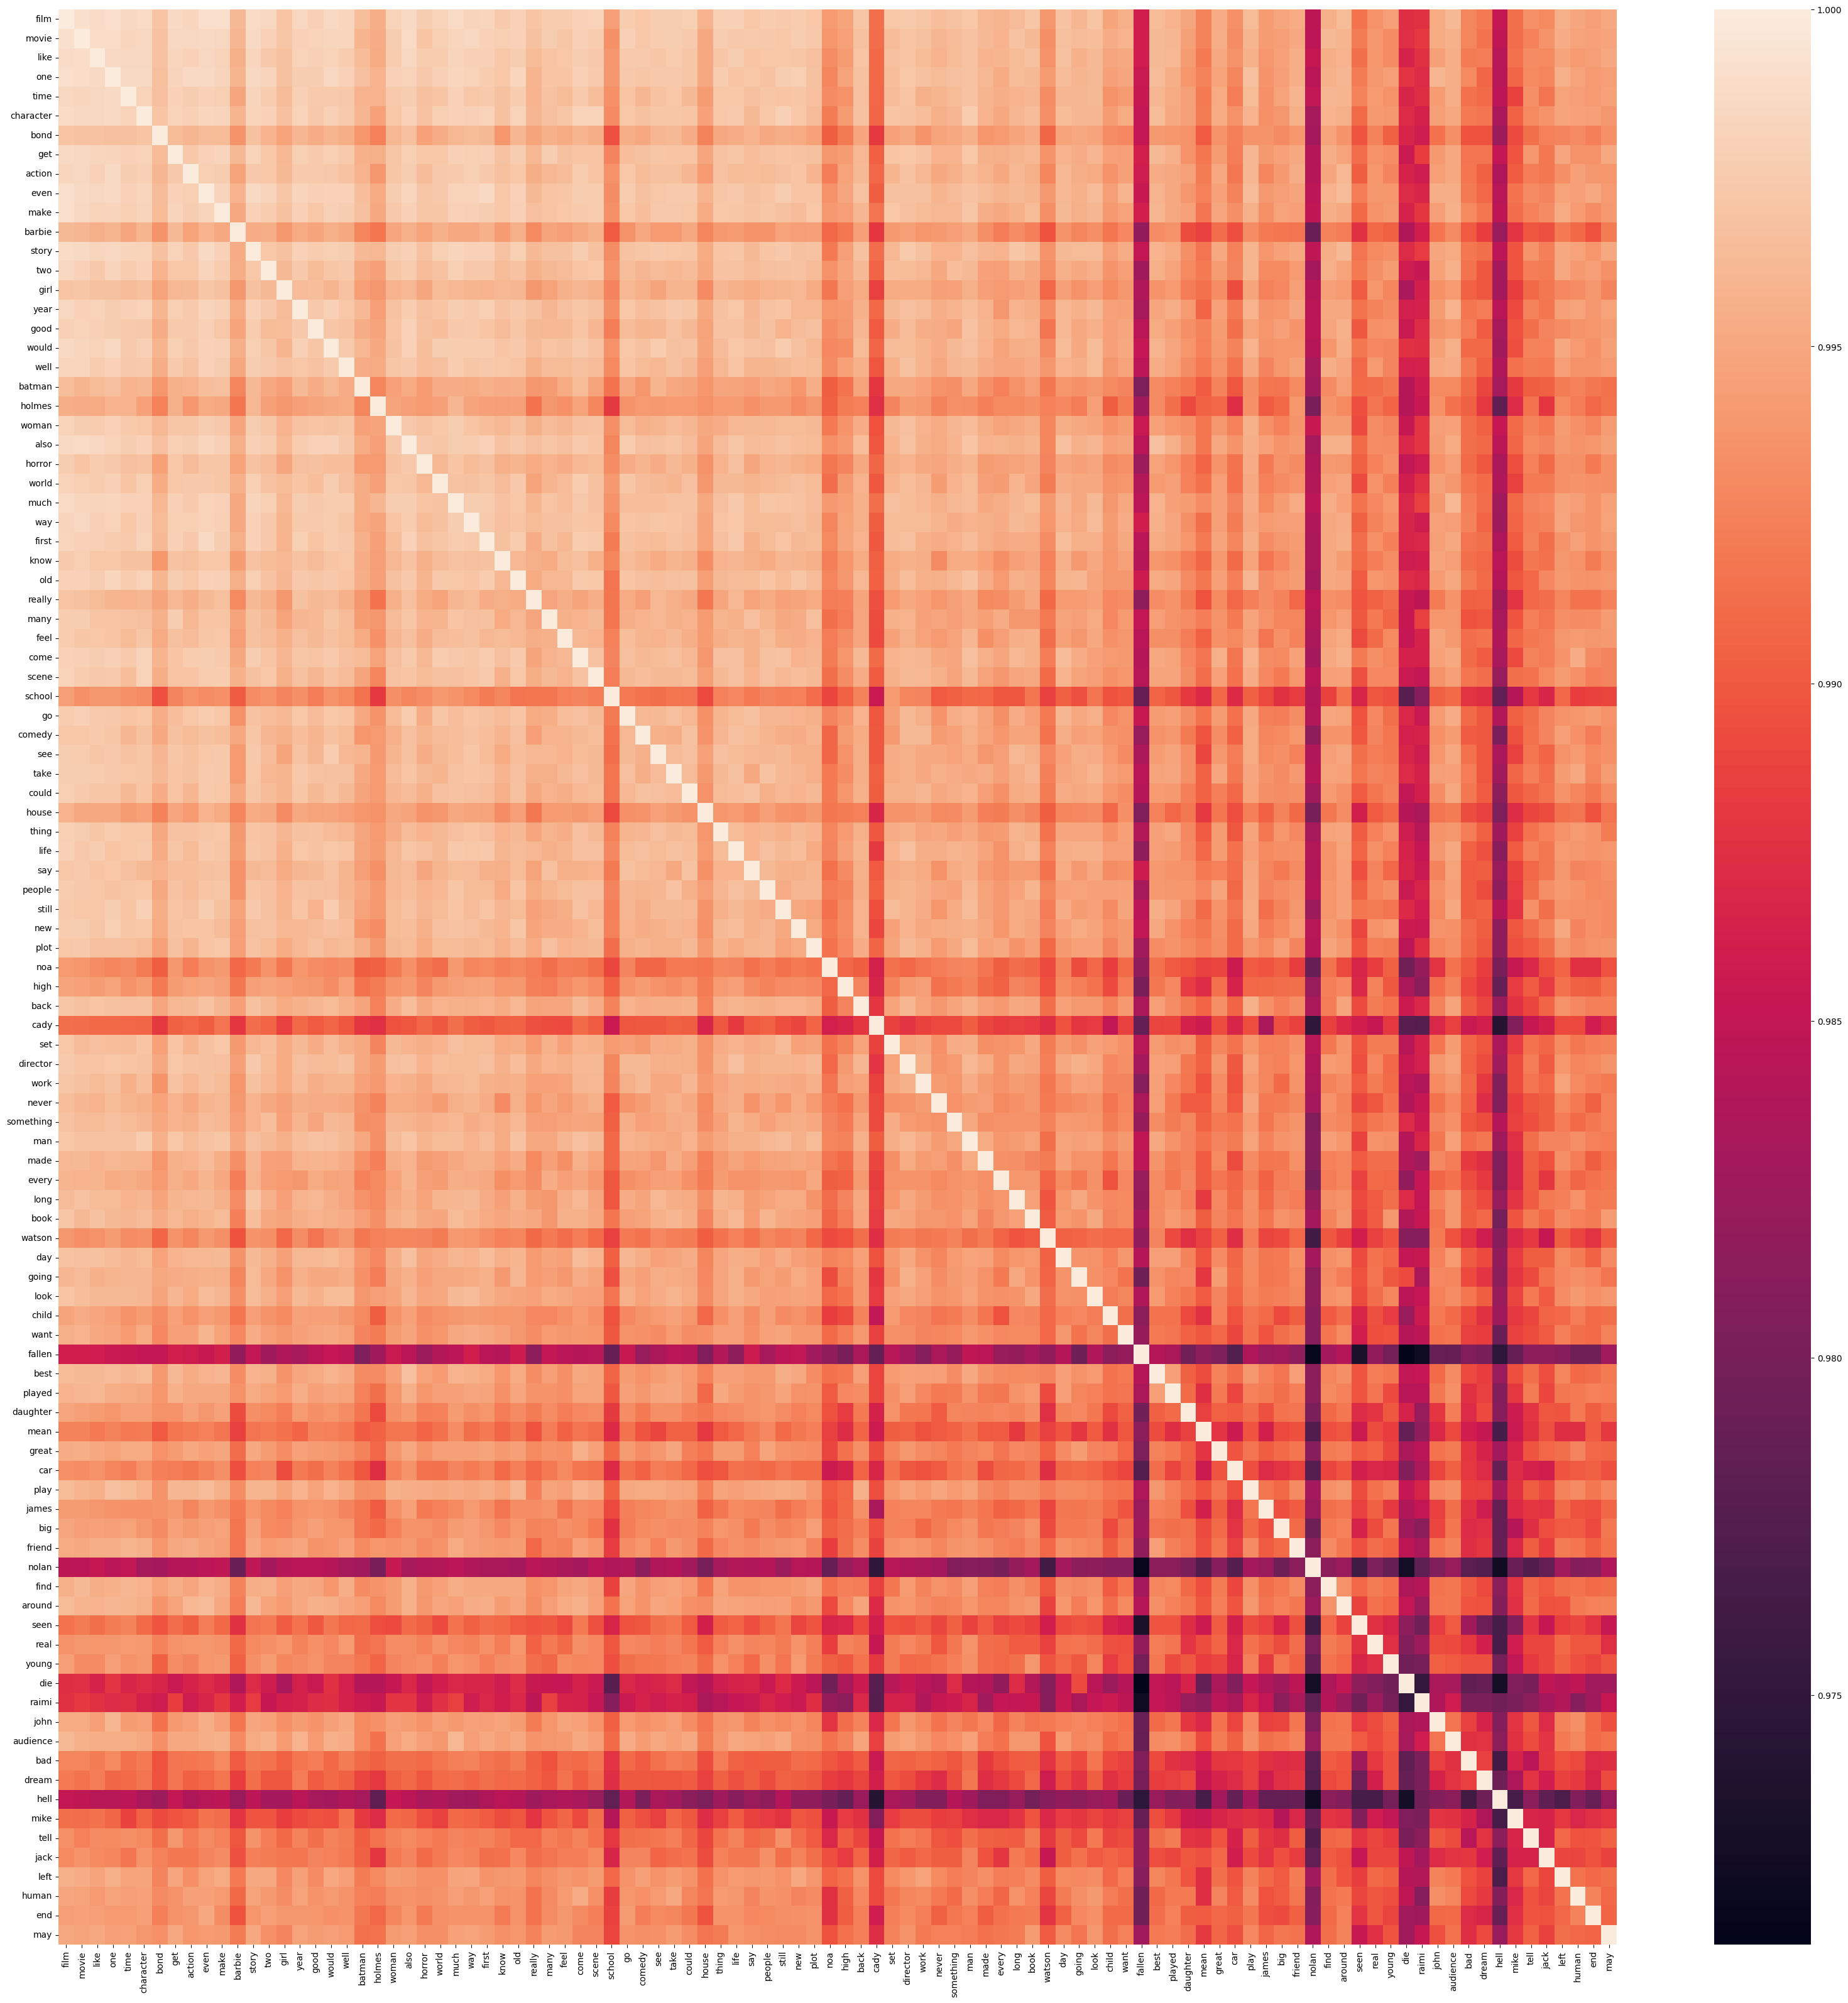

In [81]:
similarities = cosine_similarity(top100_tfidf_word_vectors,
                                 top100_tfidf_word_vectors)
fig, ax = plt.subplots(figsize=(40, 40))

sns.heatmap(ax=ax,
            data=similarities,
            xticklabels=top100_tfidf_word_vectors.index,
            yticklabels=top100_tfidf_word_vectors.index);

In [83]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_df.lemmatized_tokens)]
model_doc2vec = Doc2Vec(documents,
                        vector_size=100,
                        min_count=1,
                        workers=4)

In [84]:

model_doc2vec.infer_vector(documents[0].words)

array([ 0.04385266,  0.5866128 ,  0.19346493,  0.05295886,  0.15857169,
       -1.1073599 ,  0.25173724,  0.84978825, -0.85269237, -0.54691154,
       -1.0125643 , -0.7445291 , -0.41120693,  0.17557424, -0.49566767,
       -0.4839613 ,  0.8675119 , -0.90507495,  0.09851425, -1.487672  ,
        0.5412875 ,  0.33872074,  0.97621286, -0.05205245,  0.74267685,
        0.13057868, -0.8665399 , -0.17122814, -1.3377832 , -0.89724857,
        1.3445324 ,  0.75362843,  0.07029165,  0.95113677,  0.01427002,
        1.1140834 ,  0.07034811, -0.9837356 , -0.49354637, -0.79837424,
        0.55212605, -0.49264112, -0.33044797, -0.8829606 , -0.083024  ,
        0.03930619, -0.22130522,  0.1629601 ,  0.6982582 ,  0.5224485 ,
        0.02976106, -0.17053583,  0.2331255 , -0.3898989 , -0.5476924 ,
        0.28942975,  0.34272578, -0.26635805, -0.89104646,  0.8745385 ,
        0.5469873 ,  0.5380867 , -0.34537375,  0.41929182, -0.70018035,
        1.1210016 ,  0.64553845,  0.68342257, -0.7917075 ,  0.54

In [85]:
doc2vec_df = pd.DataFrame()

for document in documents:
    vector = pd.DataFrame(model_doc2vec.infer_vector(document.words)).transpose()
    doc2vec_df = pd.concat([doc2vec_df, vector])
doc2vec_df.shape

(200, 100)

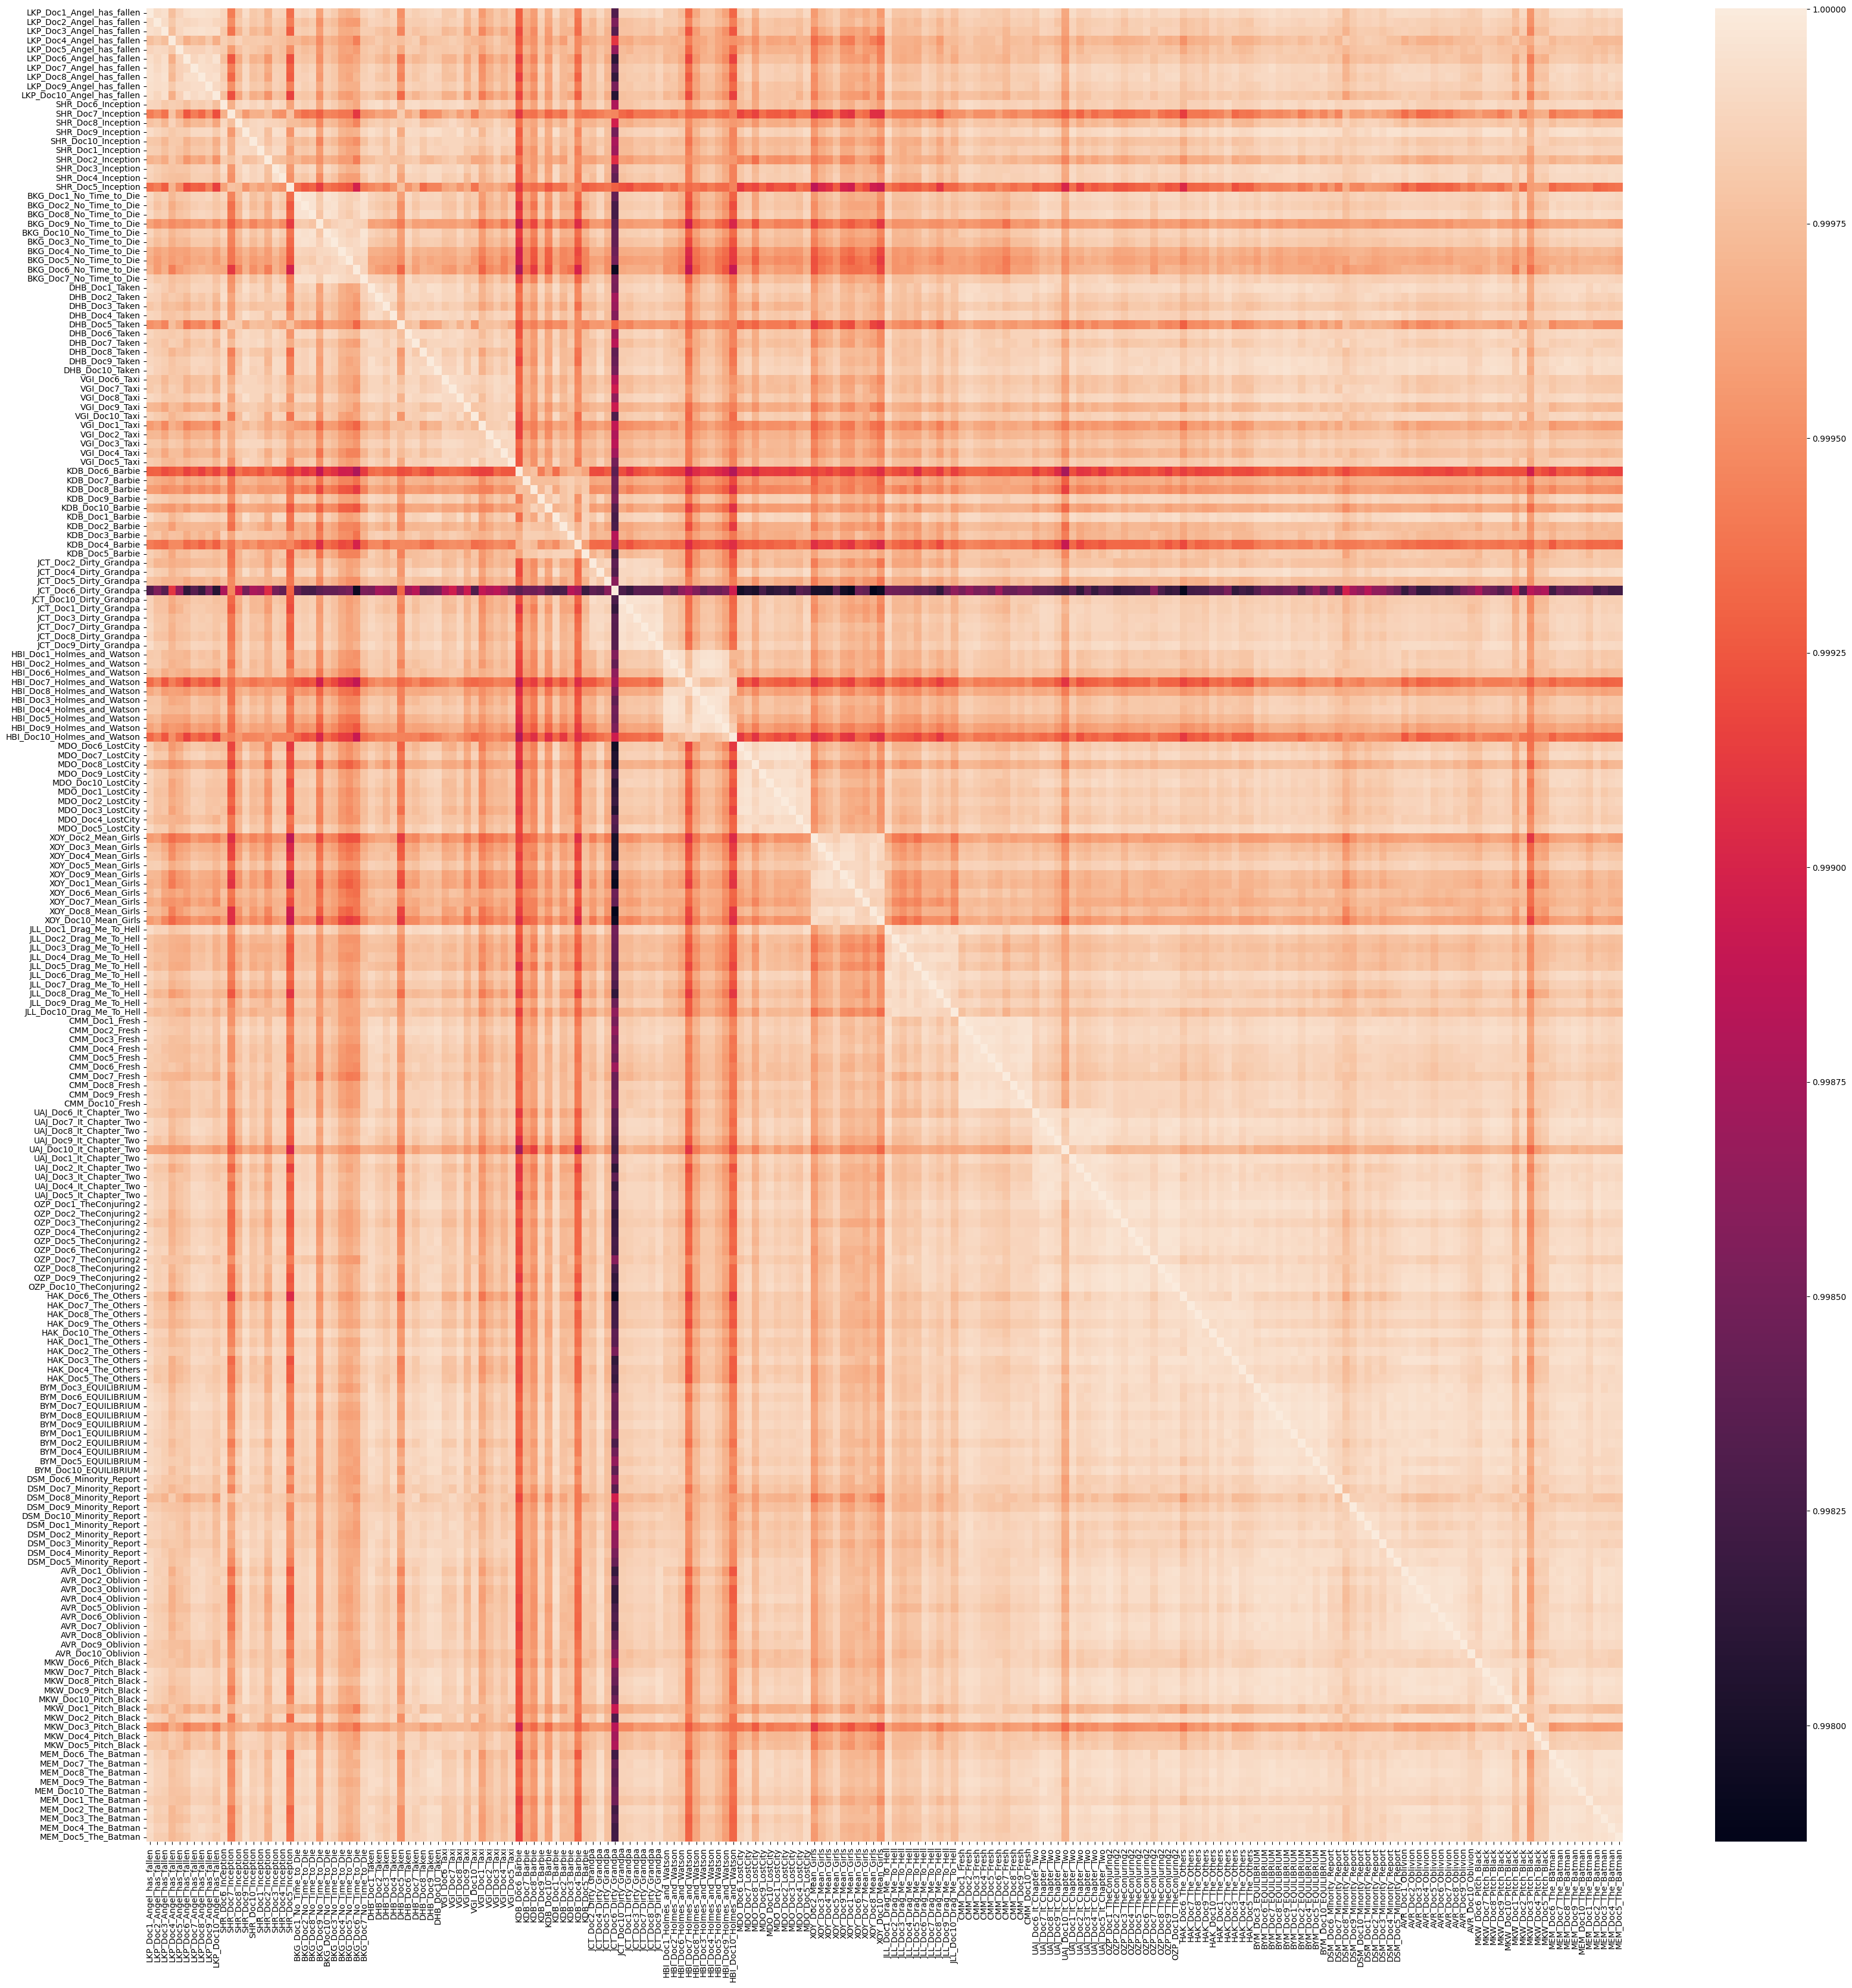

In [86]:
similarities = cosine_similarity(doc2vec_df,
                                 doc2vec_df)
fig, ax = plt.subplots(figsize=(40, 40))

sns.heatmap(ax=ax,
            data=similarities,
            xticklabels=corpus_df.DSI_Title,
            yticklabels=corpus_df.DSI_Title);